# Imports & Functions (RUN THIS FIRST)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import torch
import numpy as np
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
import pandas as pd
from torch import nn
pd.set_option('display.max_colwidth', None)
import string
import re
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

# function to remove urls
def remove_url(text):
    return re.sub('http[s]?://\S+', '', text)

# function to remove punctuations
def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

# function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return emoji_pattern.sub(r'', text)

# function to remove numbers
def remove_number(text):
    return "".join([i for i in text if not i.isdigit()])

# function to remove extra spaces
def remove_exrta_spaces(text):
    return " ".join(text.split())

# function for tokenization
def tokenization(text):
    return re.split(' ',text)

# function to remove stopwords from tokenized text
def remove_stopwords(text):
    return [i for i in text if i not in stopwords]

# function for stemming
def stemming(text):
    return [porter_stemmer.stem(word) for word in text]

# function for lemmatization
def lemmatizer(text):
    return [wordnet_lemmatizer.lemmatize(word) for word in text]

def pre_process(dataset):
    dataset['proc_tweet'] = dataset['tweet']
    # removing url
    dataset['proc_tweet'] = dataset['proc_tweet'].apply(lambda x: remove_url(x))
    # removing puntuations
    dataset['proc_tweet'] = dataset['proc_tweet'].apply(lambda x: remove_punctuation(x))
    # removing emojis
    dataset['proc_tweet'] = dataset['proc_tweet'].apply(lambda x: remove_emoji(x))
    # remove numbers
    # dataset['proc_tweet'] = dataset['proc_tweet'].apply(lambda x: remove_number(x))
    # make lower case
    # dataset['proc_tweet'] = dataset['proc_tweet'].apply(lambda x: x.lower())
    # tokenization
    # remove extra spaces
    dataset['proc_tweet'] = dataset['proc_tweet'].apply(lambda x: remove_exrta_spaces(x))
    dataset['proc_tweet']= dataset['proc_tweet'].apply(lambda x: tokenization(x))
    # remove stopwords
    # dataset['proc_tweet']= dataset['proc_tweet'].apply(lambda x: remove_stopwords(x))
    # stemming
    # dataset['proc_tweet']=dataset['proc_tweet'].apply(lambda x: stemming(x))
    # lemmatization
    dataset['proc_tweet']=dataset['proc_tweet'].apply(lambda x: lemmatizer(x))

    dataset['proc_tweet'] = dataset['proc_tweet'].apply(lambda x:' '.join(x))
    dataset['tweet'] = dataset['proc_tweet']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Vanillia RNN Models

## First Model
- Vanilla RNN
- Number of Layers 1
- Hidden Size 32
- Glove 300d


Read Files

In [ ]:
#  -- Download GloVe Files --
# !wget https://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

# file path for glove file
glovePath = "/content/glove.6B.300d.txt"

# # creating dictionary
glove = pd.read_csv(glovePath, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

--2022-01-29 10:40:31--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-29 10:40:32--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.00MB/s    in 2m 41s  

2022-01-29 10:43:13 (5.10 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

In [ ]:
from numpy.ma.core import concatenate
# reading the train csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_train_set.csv')
# reading the validation csv
data_Val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_validation_set.csv')

# pre processing the data['tweet']
pre_process(data)
# pre processing the data_Val['tweet']
pre_process(data_Val)

def create_array(tweet):
  return re.split(' ',tweet)

def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in glove_embedding:
      ar = np.zeros([1,300])
    else:
      ar = np.array([glove_embedding.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

# tranform the sentence of words to a 1x50 array using the glove

data['tweet'] = data['tweet'].apply(lambda tweet:create_array(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:transform(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:sum_array(tweet))

data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:create_array(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:transform(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:sum_array(tweet))

# split to variables
XTrain = data['tweet']
XVal = data_Val['tweet']
YTrain = data['label']
YVal = data_Val['label']

In [ ]:
# Train
XTrain = torch.tensor(XTrain,dtype=torch.float)

YTrain = torch.tensor(YTrain,dtype=torch.float)
YTrain = YTrain.to(torch.long)
YTrain = torch.nn.functional.one_hot(YTrain,num_classes=3)
YTrain = YTrain.float()
# Validation
XVal = torch.tensor(XVal,dtype=torch.float)

YVal = torch.tensor(YVal,dtype=torch.float)
YVal = YVal.to(torch.long)
YVal = torch.nn.functional.one_hot(YVal,num_classes=3)
YVal = YVal.float()

print(f"x shape: {XTrain.shape}")
print(XTrain)
print(f"x_Val shape: {XVal.shape}")
print(XVal)
print(f"y shape: {YTrain.shape}")
print(YTrain)
print(f"y_Val shape: {YVal.shape}")
print(YVal)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


x shape: torch.Size([15976, 300])
tensor([[-0.4226, -1.1508, -0.0539,  ..., -0.3592,  0.7071, -0.3606],
        [-2.9199,  1.7339, -1.1964,  ..., -3.4243,  0.3180,  1.6826],
        [-0.8554,  1.3731, -2.0530,  ..., -5.0828, -0.4969,  0.5490],
        ...,
        [-1.5591,  0.3572, -0.0653,  ..., -0.5557, -0.3443, -0.5218],
        [-2.2863,  0.7092, -1.5725,  ..., -2.3555, -0.3223, -0.1531],
        [-3.8773,  3.1693, -3.6080,  ..., -4.1248, -0.8857, -0.3447]])
x_Val shape: torch.Size([2282, 300])
tensor([[-5.7583,  5.8541, -1.6753,  ..., -6.0936, -3.3022, -3.2973],
        [-3.5578,  2.1656, -0.6907,  ..., -3.5801, -2.7964, -0.5301],
        [-1.5880,  1.1769, -0.4060,  ..., -1.8123,  0.1574, -0.8568],
        ...,
        [-1.0889,  1.8088, -2.1432,  ..., -2.0436, -0.8788, -0.9485],
        [-2.5667,  0.3689, -0.5168,  ..., -2.0777, -0.3274,  1.1764],
        [-2.7411,  2.0780, -2.3738,  ..., -1.2155, -0.3677,  1.8798]])
y shape: torch.Size([15976, 3])
tensor([[1., 0., 0.],
       

Define RNN Model

In [ ]:
class RNN(nn.Module):
  def __init__(self, inputSize, hiddenSize, numLayers, numClasses, dropoutProb):
    super(RNN,self).__init__()

    self.hiddenSize = hiddenSize
    self.numLayers = numLayers

    self.rnn = nn.RNN(inputSize, hiddenSize, numLayers, batch_first=True, dropout=dropoutProb, bidirectional=False)

    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    # Set initial hidden states
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    
    # Forward propagate RNN
    out, _ = self.rnn(x, h0)  
    
    # out: tensor of shape (batch_size, seq_length, hidden_size)
    
    # Decode the hidden state of the last time step
    out = out[:, -1, :]
    # out: (n, 128)
      
    out = self.fc(out)
    # out: (n, 10)
    return out

initialize model

In [ ]:
inputSize = XTrain.shape[1]
sequenceLength = inputSize
hiddenSize = 32
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50
batchSize = 64

model = RNN(inputSize,hiddenSize,numLayers,numClasses,0)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

trainDataset = torch.utils.data.TensorDataset(XTrain, YTrain)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=batchSize,shuffle=True)

valDataset = torch.utils.data.TensorDataset(XVal, YVal)
valLoader = torch.utils.data.DataLoader(dataset=valDataset,batch_size=batchSize,shuffle=True)

RNN(
  (rnn): RNN(300, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


train model

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

totalSteps = len(trainLoader)
n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []
for epoch in range(numEpochs):
    batch_losses,batch_f1_scores,batch_precision_scores,batch_recall_scores = [],[],[],[]
    batch_losses_Val,batch_f1_scores_Val,batch_precision_scores_Val,batch_recall_scores_Val = [],[],[],[]
    for i, (x_batch, y_batch) in enumerate(trainLoader):  

        x_batch = x_batch.unsqueeze(1)

        # Forward pass
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        
        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores.append(f1)
        
        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores.append(recall)
        n_epoch+=1

    for i, (x_batch, y_batch) in enumerate(valLoader):  
        # Val
        x_batch = x_batch.unsqueeze(1)
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)

        batch_losses_Val.append(loss.item())

        # Score
        # scores = nn.functional.softmax(y_pred, dim=1)

        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores_Val.append(f1)

        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores_Val.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores_Val.append(recall)

    iters.append(n_epoch)
    losses.append(sum(batch_losses)/len(trainLoader)) # compute *average* loss
    losses_Val.append(sum(batch_losses_Val)/len(valLoader)) # compute *average* loss

    f1_train_scores.append(sum(batch_f1_scores)/len(trainLoader))
    f1_train_scores_Val.append(sum(batch_f1_scores_Val)/len(valLoader))

    precision_train_scores.append(sum(batch_precision_scores)/len(trainLoader))
    precision_train_scores_Val.append(sum(batch_precision_scores_Val)/len(valLoader))

    recall_train_scores.append(sum(batch_recall_scores)/len(trainLoader))
    recall_train_scores_Val.append(sum(batch_recall_scores_Val)/len(valLoader))

    print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainLoader)} F1 = {sum(batch_f1_scores)/len(trainLoader)} Loss_Val = {sum(batch_losses_Val)/len(valLoader)} F1_Val = {sum(batch_f1_scores_Val)/len(valLoader)}")


Epoch   0: Loss = 1.0315808444023131 F1 = 0.4291425951378219 Loss_Val = 0.9789636880159378 F1_Val = 0.505678353986836
Epoch   1: Loss = 0.9545484795570374 F1 = 0.5302387099253582 Loss_Val = 0.9414969384670258 F1_Val = 0.5335822113181731
Epoch   2: Loss = 0.9178394689559937 F1 = 0.5552611356710895 Loss_Val = 0.9097283515665266 F1_Val = 0.5527703064259275
Epoch   3: Loss = 0.8872219071388244 F1 = 0.5683030203909722 Loss_Val = 0.8843094441625807 F1_Val = 0.5660483842952861
Epoch   4: Loss = 0.8629766254425049 F1 = 0.5784557766747731 Loss_Val = 0.8630772365464104 F1_Val = 0.5746525614373291
Epoch   5: Loss = 0.8441129703521728 F1 = 0.5873627672579731 Loss_Val = 0.8479639109638002 F1_Val = 0.5807541482355006
Epoch   6: Loss = 0.8294381530284881 F1 = 0.5966230520856659 Loss_Val = 0.8357496311267217 F1_Val = 0.5940329389302639
Epoch   7: Loss = 0.8182204158306122 F1 = 0.6100390760882836 Loss_Val = 0.8269274168544345 F1_Val = 0.598952284856845
Epoch   8: Loss = 0.8096085720062256 F1 = 0.613322

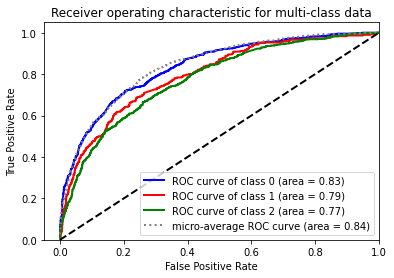

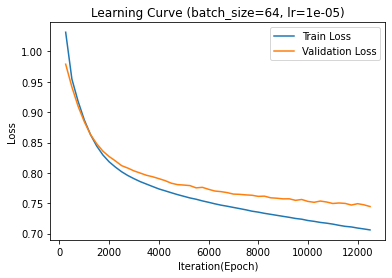

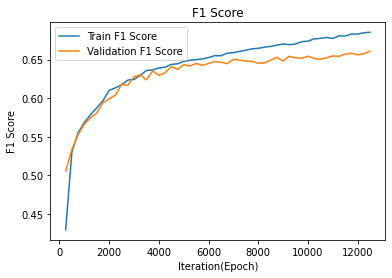

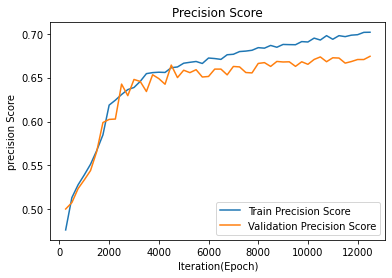

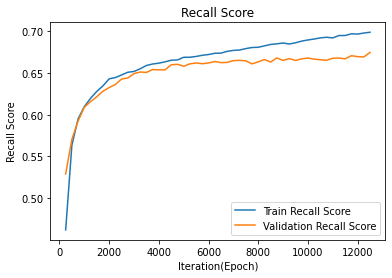

In [ ]:
validation = XVal
validation = validation.unsqueeze(1)
y_pred = model(validation)
# scores = nn.functional.softmax(y_pred, dim=1)
# print(YVal.shape)
# print(y_pred.shape)
fpr0 , tpr0, t0 = roc_curve(YVal.detach().numpy()[:,0],y_pred.detach().numpy()[:,0])
roc_auc0 = auc(fpr0, tpr0)
fpr1 , tpr1, t1 = roc_curve(YVal.detach().numpy()[:,1],y_pred.detach().numpy()[:,1])
roc_auc1 = auc(fpr1, tpr1)
fpr2 , tpr2, t2 = roc_curve(YVal.detach().numpy()[:,2],y_pred.detach().numpy()[:,2])
roc_auc2 = auc(fpr2, tpr2)

fprmicro , tprmicro, tmicro = roc_curve(YVal.ravel().detach().numpy(),y_pred.ravel().detach().numpy())
roc_aucmicro = auc(fprmicro, tprmicro)

# array_fpr = [fpr0,fpr1,fpr2]
# all_fpr = np.unique(np.concatenate([array_fpr[i] for i in range(3)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(3):
#     mean_tpr += np.interp(all_fpr, array_fpr[i], array_fpr[i])

# # Finally average it and compute AUC
# mean_tpr /= 3

# fprmacro = all_fpr
# tprmacro = mean_tpr
# roc_aucmacro = auc(fprmacro, tprmacro)
# print(fprmacro)

plt.plot(fpr0, tpr0, color='blue', lw=2,label='ROC curve of class 0 (area = {0:0.2f})'
''.format(roc_auc0))
plt.plot(fpr1, tpr1, color='red', lw=2,label='ROC curve of class 1 (area = {0:0.2f})'
''.format(roc_auc1))
plt.plot(fpr2, tpr2, color='green', lw=2,label='ROC curve of class 2 (area = {0:0.2f})'
''.format(roc_auc2))
plt.plot(fprmicro, tprmicro,':', color='grey', lw=2,label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_aucmicro))
# plt.plot(fprmacro, tprmacro,'k-.', color='grey', lw=2,label='macro-average ROC curve (area = {0:0.2f})'
# ''.format(roc_aucmacro))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

plt.title("Learning Curve (batch_size={}, lr={})".format(batchSize, learningRate))
plt.plot(iters, losses, label="Train Loss")
plt.plot(iters, losses_Val, label="Validation Loss")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("F1 Score")
plt.plot(iters, f1_train_scores, label="Train F1 Score")
plt.plot(iters, f1_train_scores_Val, label="Validation F1 Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

plt.title("Precision Score")
plt.plot(iters, precision_train_scores, label="Train Precision Score")
plt.plot(iters, precision_train_scores_Val, label="Validation Precision Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("precision Score")
plt.legend(loc='best')
plt.show()

plt.title("Recall Score")
plt.plot(iters, recall_train_scores, label="Train Recall Score")
plt.plot(iters, recall_train_scores_Val, label="Validation Recall Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Recall Score")
plt.legend(loc='best')
plt.show()

## Hidden size 32 -> 256

Read Files

In [ ]:
#  -- Download GloVe Files --
# !wget https://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

# file path for glove file
glovePath = "/content/glove.6B.300d.txt"

# # creating dictionary
glove = pd.read_csv(glovePath, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

--2022-01-29 10:40:31--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-29 10:40:32--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.00MB/s    in 2m 41s  

2022-01-29 10:43:13 (5.10 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

In [ ]:
from numpy.ma.core import concatenate
# reading the train csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_train_set.csv')
# reading the validation csv
data_Val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_validation_set.csv')

# pre processing the data['tweet']
pre_process(data)
# pre processing the data_Val['tweet']
pre_process(data_Val)

def create_array(tweet):
  return re.split(' ',tweet)

def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in glove_embedding:
      ar = np.zeros([1,300])
    else:
      ar = np.array([glove_embedding.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

# tranform the sentence of words to a 1x50 array using the glove

data['tweet'] = data['tweet'].apply(lambda tweet:create_array(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:transform(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:sum_array(tweet))

data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:create_array(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:transform(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:sum_array(tweet))

# split to variables
XTrain = data['tweet']
XVal = data_Val['tweet']
YTrain = data['label']
YVal = data_Val['label']

In [ ]:
# Train
XTrain = torch.tensor(XTrain,dtype=torch.float)

YTrain = torch.tensor(YTrain,dtype=torch.float)
YTrain = YTrain.to(torch.long)
YTrain = torch.nn.functional.one_hot(YTrain,num_classes=3)
YTrain = YTrain.float()
# Validation
XVal = torch.tensor(XVal,dtype=torch.float)

YVal = torch.tensor(YVal,dtype=torch.float)
YVal = YVal.to(torch.long)
YVal = torch.nn.functional.one_hot(YVal,num_classes=3)
YVal = YVal.float()

print(f"x shape: {XTrain.shape}")
print(XTrain)
print(f"x_Val shape: {XVal.shape}")
print(XVal)
print(f"y shape: {YTrain.shape}")
print(YTrain)
print(f"y_Val shape: {YVal.shape}")
print(YVal)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


x shape: torch.Size([15976, 300])
tensor([[-0.4226, -1.1508, -0.0539,  ..., -0.3592,  0.7071, -0.3606],
        [-2.9199,  1.7339, -1.1964,  ..., -3.4243,  0.3180,  1.6826],
        [-0.8554,  1.3731, -2.0530,  ..., -5.0828, -0.4969,  0.5490],
        ...,
        [-1.5591,  0.3572, -0.0653,  ..., -0.5557, -0.3443, -0.5218],
        [-2.2863,  0.7092, -1.5725,  ..., -2.3555, -0.3223, -0.1531],
        [-3.8773,  3.1693, -3.6080,  ..., -4.1248, -0.8857, -0.3447]])
x_Val shape: torch.Size([2282, 300])
tensor([[-5.7583,  5.8541, -1.6753,  ..., -6.0936, -3.3022, -3.2973],
        [-3.5578,  2.1656, -0.6907,  ..., -3.5801, -2.7964, -0.5301],
        [-1.5880,  1.1769, -0.4060,  ..., -1.8123,  0.1574, -0.8568],
        ...,
        [-1.0889,  1.8088, -2.1432,  ..., -2.0436, -0.8788, -0.9485],
        [-2.5667,  0.3689, -0.5168,  ..., -2.0777, -0.3274,  1.1764],
        [-2.7411,  2.0780, -2.3738,  ..., -1.2155, -0.3677,  1.8798]])
y shape: torch.Size([15976, 3])
tensor([[1., 0., 0.],
       

Define RNN Model

In [ ]:
class RNN(nn.Module):
  def __init__(self, inputSize, hiddenSize, numLayers, numClasses, dropoutProb):
    super(RNN,self).__init__()

    self.hiddenSize = hiddenSize
    self.numLayers = numLayers

    self.rnn = nn.RNN(inputSize, hiddenSize, numLayers, batch_first=True, dropout=dropoutProb, bidirectional=False)

    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    # Set initial hidden states
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    
    # Forward propagate RNN
    out, _ = self.rnn(x, h0)  
    
    # out: tensor of shape (batch_size, seq_length, hidden_size)
    
    # Decode the hidden state of the last time step
    out = out[:, -1, :]
    # out: (n, 128)
      
    out = self.fc(out)
    # out: (n, 10)
    return out

initialize model

In [ ]:
inputSize = XTrain.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50
batchSize = 64

model = RNN(inputSize,hiddenSize,numLayers,numClasses,0)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

trainDataset = torch.utils.data.TensorDataset(XTrain, YTrain)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=batchSize,shuffle=True)

valDataset = torch.utils.data.TensorDataset(XVal, YVal)
valLoader = torch.utils.data.DataLoader(dataset=valDataset,batch_size=batchSize,shuffle=True)

RNN(
  (rnn): RNN(300, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


train model

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

totalSteps = len(trainLoader)
n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []
for epoch in range(numEpochs):
    batch_losses,batch_f1_scores,batch_precision_scores,batch_recall_scores = [],[],[],[]
    batch_losses_Val,batch_f1_scores_Val,batch_precision_scores_Val,batch_recall_scores_Val = [],[],[],[]
    for i, (x_batch, y_batch) in enumerate(trainLoader):  

        x_batch = x_batch.unsqueeze(1)

        # Forward pass
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        
        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores.append(f1)
        
        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores.append(recall)
        n_epoch+=1

    for i, (x_batch, y_batch) in enumerate(valLoader):  
        # Val
        x_batch = x_batch.unsqueeze(1)
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)

        batch_losses_Val.append(loss.item())

        # Score
        # scores = nn.functional.softmax(y_pred, dim=1)

        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores_Val.append(f1)

        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores_Val.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores_Val.append(recall)

    iters.append(n_epoch)
    losses.append(sum(batch_losses)/len(trainLoader)) # compute *average* loss
    losses_Val.append(sum(batch_losses_Val)/len(valLoader)) # compute *average* loss

    f1_train_scores.append(sum(batch_f1_scores)/len(trainLoader))
    f1_train_scores_Val.append(sum(batch_f1_scores_Val)/len(valLoader))

    precision_train_scores.append(sum(batch_precision_scores)/len(trainLoader))
    precision_train_scores_Val.append(sum(batch_precision_scores_Val)/len(valLoader))

    recall_train_scores.append(sum(batch_recall_scores)/len(trainLoader))
    recall_train_scores_Val.append(sum(batch_recall_scores_Val)/len(valLoader))

    print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainLoader)} F1 = {sum(batch_f1_scores)/len(trainLoader)} Loss_Val = {sum(batch_losses_Val)/len(valLoader)} F1_Val = {sum(batch_f1_scores_Val)/len(valLoader)}")


Epoch   0: Loss = 1.0315808444023131 F1 = 0.4291425951378219 Loss_Val = 0.9789636880159378 F1_Val = 0.505678353986836
Epoch   1: Loss = 0.9545484795570374 F1 = 0.5302387099253582 Loss_Val = 0.9414969384670258 F1_Val = 0.5335822113181731
Epoch   2: Loss = 0.9178394689559937 F1 = 0.5552611356710895 Loss_Val = 0.9097283515665266 F1_Val = 0.5527703064259275
Epoch   3: Loss = 0.8872219071388244 F1 = 0.5683030203909722 Loss_Val = 0.8843094441625807 F1_Val = 0.5660483842952861
Epoch   4: Loss = 0.8629766254425049 F1 = 0.5784557766747731 Loss_Val = 0.8630772365464104 F1_Val = 0.5746525614373291
Epoch   5: Loss = 0.8441129703521728 F1 = 0.5873627672579731 Loss_Val = 0.8479639109638002 F1_Val = 0.5807541482355006
Epoch   6: Loss = 0.8294381530284881 F1 = 0.5966230520856659 Loss_Val = 0.8357496311267217 F1_Val = 0.5940329389302639
Epoch   7: Loss = 0.8182204158306122 F1 = 0.6100390760882836 Loss_Val = 0.8269274168544345 F1_Val = 0.598952284856845
Epoch   8: Loss = 0.8096085720062256 F1 = 0.613322

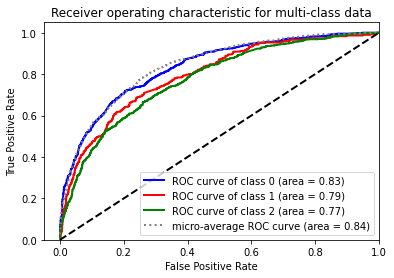

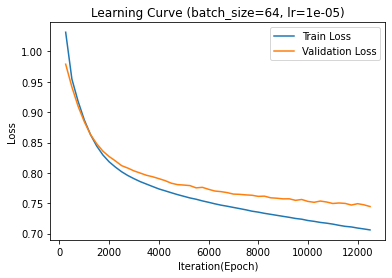

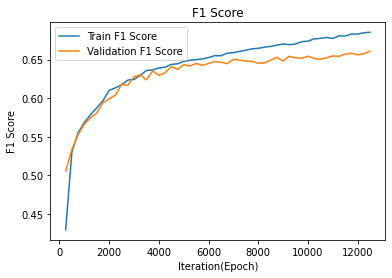

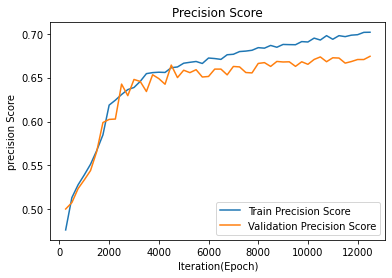

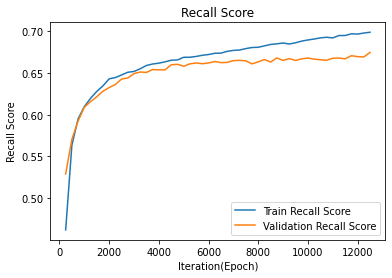

In [ ]:
validation = XVal
validation = validation.unsqueeze(1)
y_pred = model(validation)
# scores = nn.functional.softmax(y_pred, dim=1)
# print(YVal.shape)
# print(y_pred.shape)
fpr0 , tpr0, t0 = roc_curve(YVal.detach().numpy()[:,0],y_pred.detach().numpy()[:,0])
roc_auc0 = auc(fpr0, tpr0)
fpr1 , tpr1, t1 = roc_curve(YVal.detach().numpy()[:,1],y_pred.detach().numpy()[:,1])
roc_auc1 = auc(fpr1, tpr1)
fpr2 , tpr2, t2 = roc_curve(YVal.detach().numpy()[:,2],y_pred.detach().numpy()[:,2])
roc_auc2 = auc(fpr2, tpr2)

fprmicro , tprmicro, tmicro = roc_curve(YVal.ravel().detach().numpy(),y_pred.ravel().detach().numpy())
roc_aucmicro = auc(fprmicro, tprmicro)

# array_fpr = [fpr0,fpr1,fpr2]
# all_fpr = np.unique(np.concatenate([array_fpr[i] for i in range(3)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(3):
#     mean_tpr += np.interp(all_fpr, array_fpr[i], array_fpr[i])

# # Finally average it and compute AUC
# mean_tpr /= 3

# fprmacro = all_fpr
# tprmacro = mean_tpr
# roc_aucmacro = auc(fprmacro, tprmacro)
# print(fprmacro)

plt.plot(fpr0, tpr0, color='blue', lw=2,label='ROC curve of class 0 (area = {0:0.2f})'
''.format(roc_auc0))
plt.plot(fpr1, tpr1, color='red', lw=2,label='ROC curve of class 1 (area = {0:0.2f})'
''.format(roc_auc1))
plt.plot(fpr2, tpr2, color='green', lw=2,label='ROC curve of class 2 (area = {0:0.2f})'
''.format(roc_auc2))
plt.plot(fprmicro, tprmicro,':', color='grey', lw=2,label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_aucmicro))
# plt.plot(fprmacro, tprmacro,'k-.', color='grey', lw=2,label='macro-average ROC curve (area = {0:0.2f})'
# ''.format(roc_aucmacro))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

plt.title("Learning Curve (batch_size={}, lr={})".format(batchSize, learningRate))
plt.plot(iters, losses, label="Train Loss")
plt.plot(iters, losses_Val, label="Validation Loss")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("F1 Score")
plt.plot(iters, f1_train_scores, label="Train F1 Score")
plt.plot(iters, f1_train_scores_Val, label="Validation F1 Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

plt.title("Precision Score")
plt.plot(iters, precision_train_scores, label="Train Precision Score")
plt.plot(iters, precision_train_scores_Val, label="Validation Precision Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("precision Score")
plt.legend(loc='best')
plt.show()

plt.title("Recall Score")
plt.plot(iters, recall_train_scores, label="Train Recall Score")
plt.plot(iters, recall_train_scores_Val, label="Validation Recall Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Recall Score")
plt.legend(loc='best')
plt.show()

## Hidden size 256 -> 1024

Read Files

In [ ]:
#  -- Download GloVe Files --
# !wget https://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

# file path for glove file
glovePath = "/content/glove.6B.300d.txt"

# # creating dictionary
glove = pd.read_csv(glovePath, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

--2022-01-29 10:40:31--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-29 10:40:32--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.00MB/s    in 2m 41s  

2022-01-29 10:43:13 (5.10 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

In [ ]:
from numpy.ma.core import concatenate
# reading the train csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_train_set.csv')
# reading the validation csv
data_Val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_validation_set.csv')

# pre processing the data['tweet']
pre_process(data)
# pre processing the data_Val['tweet']
pre_process(data_Val)

def create_array(tweet):
  return re.split(' ',tweet)

def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in glove_embedding:
      ar = np.zeros([1,300])
    else:
      ar = np.array([glove_embedding.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

# tranform the sentence of words to a 1x50 array using the glove

data['tweet'] = data['tweet'].apply(lambda tweet:create_array(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:transform(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:sum_array(tweet))

data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:create_array(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:transform(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:sum_array(tweet))

# split to variables
XTrain = data['tweet']
XVal = data_Val['tweet']
YTrain = data['label']
YVal = data_Val['label']

In [ ]:
# Train
XTrain = torch.tensor(XTrain,dtype=torch.float)

YTrain = torch.tensor(YTrain,dtype=torch.float)
YTrain = YTrain.to(torch.long)
YTrain = torch.nn.functional.one_hot(YTrain,num_classes=3)
YTrain = YTrain.float()
# Validation
XVal = torch.tensor(XVal,dtype=torch.float)

YVal = torch.tensor(YVal,dtype=torch.float)
YVal = YVal.to(torch.long)
YVal = torch.nn.functional.one_hot(YVal,num_classes=3)
YVal = YVal.float()

print(f"x shape: {XTrain.shape}")
print(XTrain)
print(f"x_Val shape: {XVal.shape}")
print(XVal)
print(f"y shape: {YTrain.shape}")
print(YTrain)
print(f"y_Val shape: {YVal.shape}")
print(YVal)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


x shape: torch.Size([15976, 300])
tensor([[-0.4226, -1.1508, -0.0539,  ..., -0.3592,  0.7071, -0.3606],
        [-2.9199,  1.7339, -1.1964,  ..., -3.4243,  0.3180,  1.6826],
        [-0.8554,  1.3731, -2.0530,  ..., -5.0828, -0.4969,  0.5490],
        ...,
        [-1.5591,  0.3572, -0.0653,  ..., -0.5557, -0.3443, -0.5218],
        [-2.2863,  0.7092, -1.5725,  ..., -2.3555, -0.3223, -0.1531],
        [-3.8773,  3.1693, -3.6080,  ..., -4.1248, -0.8857, -0.3447]])
x_Val shape: torch.Size([2282, 300])
tensor([[-5.7583,  5.8541, -1.6753,  ..., -6.0936, -3.3022, -3.2973],
        [-3.5578,  2.1656, -0.6907,  ..., -3.5801, -2.7964, -0.5301],
        [-1.5880,  1.1769, -0.4060,  ..., -1.8123,  0.1574, -0.8568],
        ...,
        [-1.0889,  1.8088, -2.1432,  ..., -2.0436, -0.8788, -0.9485],
        [-2.5667,  0.3689, -0.5168,  ..., -2.0777, -0.3274,  1.1764],
        [-2.7411,  2.0780, -2.3738,  ..., -1.2155, -0.3677,  1.8798]])
y shape: torch.Size([15976, 3])
tensor([[1., 0., 0.],
       

Define RNN Model

In [ ]:
class RNN(nn.Module):
  def __init__(self, inputSize, hiddenSize, numLayers, numClasses, dropoutProb):
    super(RNN,self).__init__()

    self.hiddenSize = hiddenSize
    self.numLayers = numLayers

    self.rnn = nn.RNN(inputSize, hiddenSize, numLayers, batch_first=True, dropout=dropoutProb, bidirectional=False)

    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    # Set initial hidden states
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    
    # Forward propagate RNN
    out, _ = self.rnn(x, h0)  
    
    # out: tensor of shape (batch_size, seq_length, hidden_size)
    
    # Decode the hidden state of the last time step
    out = out[:, -1, :]
    # out: (n, 128)
      
    out = self.fc(out)
    # out: (n, 10)
    return out

initialize model

In [ ]:
inputSize = XTrain.shape[1]
sequenceLength = inputSize
hiddenSize = 1024
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50
batchSize = 64

model = RNN(inputSize,hiddenSize,numLayers,numClasses,0)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

trainDataset = torch.utils.data.TensorDataset(XTrain, YTrain)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=batchSize,shuffle=True)

valDataset = torch.utils.data.TensorDataset(XVal, YVal)
valLoader = torch.utils.data.DataLoader(dataset=valDataset,batch_size=batchSize,shuffle=True)

RNN(
  (rnn): RNN(300, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


train model

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

totalSteps = len(trainLoader)
n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []
for epoch in range(numEpochs):
    batch_losses,batch_f1_scores,batch_precision_scores,batch_recall_scores = [],[],[],[]
    batch_losses_Val,batch_f1_scores_Val,batch_precision_scores_Val,batch_recall_scores_Val = [],[],[],[]
    for i, (x_batch, y_batch) in enumerate(trainLoader):  

        x_batch = x_batch.unsqueeze(1)

        # Forward pass
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        
        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores.append(f1)
        
        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores.append(recall)
        n_epoch+=1

    for i, (x_batch, y_batch) in enumerate(valLoader):  
        # Val
        x_batch = x_batch.unsqueeze(1)
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)

        batch_losses_Val.append(loss.item())

        # Score
        # scores = nn.functional.softmax(y_pred, dim=1)

        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores_Val.append(f1)

        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores_Val.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores_Val.append(recall)

    iters.append(n_epoch)
    losses.append(sum(batch_losses)/len(trainLoader)) # compute *average* loss
    losses_Val.append(sum(batch_losses_Val)/len(valLoader)) # compute *average* loss

    f1_train_scores.append(sum(batch_f1_scores)/len(trainLoader))
    f1_train_scores_Val.append(sum(batch_f1_scores_Val)/len(valLoader))

    precision_train_scores.append(sum(batch_precision_scores)/len(trainLoader))
    precision_train_scores_Val.append(sum(batch_precision_scores_Val)/len(valLoader))

    recall_train_scores.append(sum(batch_recall_scores)/len(trainLoader))
    recall_train_scores_Val.append(sum(batch_recall_scores_Val)/len(valLoader))

    print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainLoader)} F1 = {sum(batch_f1_scores)/len(trainLoader)} Loss_Val = {sum(batch_losses_Val)/len(valLoader)} F1_Val = {sum(batch_f1_scores_Val)/len(valLoader)}")


Epoch   0: Loss = 1.0315808444023131 F1 = 0.4291425951378219 Loss_Val = 0.9789636880159378 F1_Val = 0.505678353986836
Epoch   1: Loss = 0.9545484795570374 F1 = 0.5302387099253582 Loss_Val = 0.9414969384670258 F1_Val = 0.5335822113181731
Epoch   2: Loss = 0.9178394689559937 F1 = 0.5552611356710895 Loss_Val = 0.9097283515665266 F1_Val = 0.5527703064259275
Epoch   3: Loss = 0.8872219071388244 F1 = 0.5683030203909722 Loss_Val = 0.8843094441625807 F1_Val = 0.5660483842952861
Epoch   4: Loss = 0.8629766254425049 F1 = 0.5784557766747731 Loss_Val = 0.8630772365464104 F1_Val = 0.5746525614373291
Epoch   5: Loss = 0.8441129703521728 F1 = 0.5873627672579731 Loss_Val = 0.8479639109638002 F1_Val = 0.5807541482355006
Epoch   6: Loss = 0.8294381530284881 F1 = 0.5966230520856659 Loss_Val = 0.8357496311267217 F1_Val = 0.5940329389302639
Epoch   7: Loss = 0.8182204158306122 F1 = 0.6100390760882836 Loss_Val = 0.8269274168544345 F1_Val = 0.598952284856845
Epoch   8: Loss = 0.8096085720062256 F1 = 0.613322

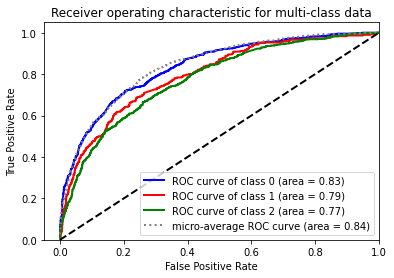

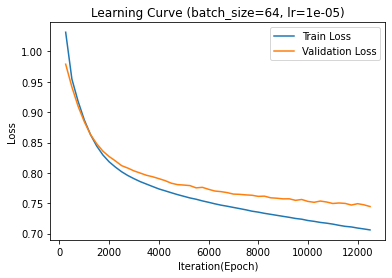

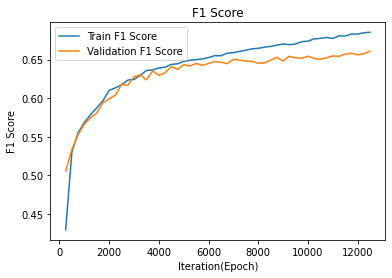

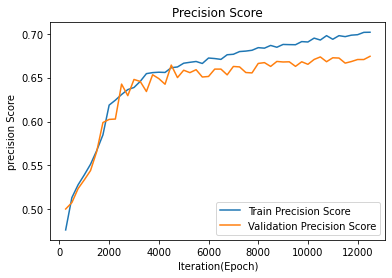

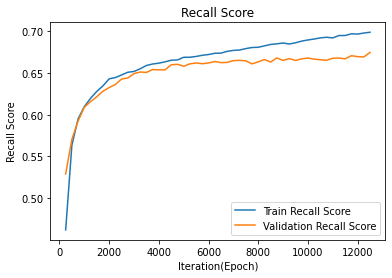

In [ ]:
validation = XVal
validation = validation.unsqueeze(1)
y_pred = model(validation)
# scores = nn.functional.softmax(y_pred, dim=1)
# print(YVal.shape)
# print(y_pred.shape)
fpr0 , tpr0, t0 = roc_curve(YVal.detach().numpy()[:,0],y_pred.detach().numpy()[:,0])
roc_auc0 = auc(fpr0, tpr0)
fpr1 , tpr1, t1 = roc_curve(YVal.detach().numpy()[:,1],y_pred.detach().numpy()[:,1])
roc_auc1 = auc(fpr1, tpr1)
fpr2 , tpr2, t2 = roc_curve(YVal.detach().numpy()[:,2],y_pred.detach().numpy()[:,2])
roc_auc2 = auc(fpr2, tpr2)

fprmicro , tprmicro, tmicro = roc_curve(YVal.ravel().detach().numpy(),y_pred.ravel().detach().numpy())
roc_aucmicro = auc(fprmicro, tprmicro)

# array_fpr = [fpr0,fpr1,fpr2]
# all_fpr = np.unique(np.concatenate([array_fpr[i] for i in range(3)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(3):
#     mean_tpr += np.interp(all_fpr, array_fpr[i], array_fpr[i])

# # Finally average it and compute AUC
# mean_tpr /= 3

# fprmacro = all_fpr
# tprmacro = mean_tpr
# roc_aucmacro = auc(fprmacro, tprmacro)
# print(fprmacro)

plt.plot(fpr0, tpr0, color='blue', lw=2,label='ROC curve of class 0 (area = {0:0.2f})'
''.format(roc_auc0))
plt.plot(fpr1, tpr1, color='red', lw=2,label='ROC curve of class 1 (area = {0:0.2f})'
''.format(roc_auc1))
plt.plot(fpr2, tpr2, color='green', lw=2,label='ROC curve of class 2 (area = {0:0.2f})'
''.format(roc_auc2))
plt.plot(fprmicro, tprmicro,':', color='grey', lw=2,label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_aucmicro))
# plt.plot(fprmacro, tprmacro,'k-.', color='grey', lw=2,label='macro-average ROC curve (area = {0:0.2f})'
# ''.format(roc_aucmacro))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

plt.title("Learning Curve (batch_size={}, lr={})".format(batchSize, learningRate))
plt.plot(iters, losses, label="Train Loss")
plt.plot(iters, losses_Val, label="Validation Loss")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("F1 Score")
plt.plot(iters, f1_train_scores, label="Train F1 Score")
plt.plot(iters, f1_train_scores_Val, label="Validation F1 Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

plt.title("Precision Score")
plt.plot(iters, precision_train_scores, label="Train Precision Score")
plt.plot(iters, precision_train_scores_Val, label="Validation Precision Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("precision Score")
plt.legend(loc='best')
plt.show()

plt.title("Recall Score")
plt.plot(iters, recall_train_scores, label="Train Recall Score")
plt.plot(iters, recall_train_scores_Val, label="Validation Recall Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Recall Score")
plt.legend(loc='best')
plt.show()

## Hidden Size = 256, Number of Layers 2

Read Files

In [ ]:
#  -- Download GloVe Files --
# !wget https://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

# file path for glove file
glovePath = "/content/glove.6B.300d.txt"

# # creating dictionary
glove = pd.read_csv(glovePath, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

--2022-01-29 10:40:31--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-29 10:40:32--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.00MB/s    in 2m 41s  

2022-01-29 10:43:13 (5.10 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

In [ ]:
from numpy.ma.core import concatenate
# reading the train csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_train_set.csv')
# reading the validation csv
data_Val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_validation_set.csv')

# pre processing the data['tweet']
pre_process(data)
# pre processing the data_Val['tweet']
pre_process(data_Val)

def create_array(tweet):
  return re.split(' ',tweet)

def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in glove_embedding:
      ar = np.zeros([1,300])
    else:
      ar = np.array([glove_embedding.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

# tranform the sentence of words to a 1x50 array using the glove

data['tweet'] = data['tweet'].apply(lambda tweet:create_array(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:transform(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:sum_array(tweet))

data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:create_array(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:transform(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:sum_array(tweet))

# split to variables
XTrain = data['tweet']
XVal = data_Val['tweet']
YTrain = data['label']
YVal = data_Val['label']

In [ ]:
# Train
XTrain = torch.tensor(XTrain,dtype=torch.float)

YTrain = torch.tensor(YTrain,dtype=torch.float)
YTrain = YTrain.to(torch.long)
YTrain = torch.nn.functional.one_hot(YTrain,num_classes=3)
YTrain = YTrain.float()
# Validation
XVal = torch.tensor(XVal,dtype=torch.float)

YVal = torch.tensor(YVal,dtype=torch.float)
YVal = YVal.to(torch.long)
YVal = torch.nn.functional.one_hot(YVal,num_classes=3)
YVal = YVal.float()

print(f"x shape: {XTrain.shape}")
print(XTrain)
print(f"x_Val shape: {XVal.shape}")
print(XVal)
print(f"y shape: {YTrain.shape}")
print(YTrain)
print(f"y_Val shape: {YVal.shape}")
print(YVal)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


x shape: torch.Size([15976, 300])
tensor([[-0.4226, -1.1508, -0.0539,  ..., -0.3592,  0.7071, -0.3606],
        [-2.9199,  1.7339, -1.1964,  ..., -3.4243,  0.3180,  1.6826],
        [-0.8554,  1.3731, -2.0530,  ..., -5.0828, -0.4969,  0.5490],
        ...,
        [-1.5591,  0.3572, -0.0653,  ..., -0.5557, -0.3443, -0.5218],
        [-2.2863,  0.7092, -1.5725,  ..., -2.3555, -0.3223, -0.1531],
        [-3.8773,  3.1693, -3.6080,  ..., -4.1248, -0.8857, -0.3447]])
x_Val shape: torch.Size([2282, 300])
tensor([[-5.7583,  5.8541, -1.6753,  ..., -6.0936, -3.3022, -3.2973],
        [-3.5578,  2.1656, -0.6907,  ..., -3.5801, -2.7964, -0.5301],
        [-1.5880,  1.1769, -0.4060,  ..., -1.8123,  0.1574, -0.8568],
        ...,
        [-1.0889,  1.8088, -2.1432,  ..., -2.0436, -0.8788, -0.9485],
        [-2.5667,  0.3689, -0.5168,  ..., -2.0777, -0.3274,  1.1764],
        [-2.7411,  2.0780, -2.3738,  ..., -1.2155, -0.3677,  1.8798]])
y shape: torch.Size([15976, 3])
tensor([[1., 0., 0.],
       

Define RNN Model

In [ ]:
class RNN(nn.Module):
  def __init__(self, inputSize, hiddenSize, numLayers, numClasses, dropoutProb):
    super(RNN,self).__init__()

    self.hiddenSize = hiddenSize
    self.numLayers = numLayers

    self.rnn = nn.RNN(inputSize, hiddenSize, numLayers, batch_first=True, dropout=dropoutProb, bidirectional=False)

    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    # Set initial hidden states
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    
    # Forward propagate RNN
    out, _ = self.rnn(x, h0)  
    
    # out: tensor of shape (batch_size, seq_length, hidden_size)
    
    # Decode the hidden state of the last time step
    out = out[:, -1, :]
    # out: (n, 128)
      
    out = self.fc(out)
    # out: (n, 10)
    return out

initialize model

In [ ]:
inputSize = XTrain.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 2
numClasses = 3

learningRate = 0.00001
numEpochs = 50
batchSize = 64

model = RNN(inputSize,hiddenSize,numLayers,numClasses,0)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

trainDataset = torch.utils.data.TensorDataset(XTrain, YTrain)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=batchSize,shuffle=True)

valDataset = torch.utils.data.TensorDataset(XVal, YVal)
valLoader = torch.utils.data.DataLoader(dataset=valDataset,batch_size=batchSize,shuffle=True)

RNN(
  (rnn): RNN(300, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


train model

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

totalSteps = len(trainLoader)
n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []
for epoch in range(numEpochs):
    batch_losses,batch_f1_scores,batch_precision_scores,batch_recall_scores = [],[],[],[]
    batch_losses_Val,batch_f1_scores_Val,batch_precision_scores_Val,batch_recall_scores_Val = [],[],[],[]
    for i, (x_batch, y_batch) in enumerate(trainLoader):  

        x_batch = x_batch.unsqueeze(1)

        # Forward pass
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        
        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores.append(f1)
        
        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores.append(recall)
        n_epoch+=1

    for i, (x_batch, y_batch) in enumerate(valLoader):  
        # Val
        x_batch = x_batch.unsqueeze(1)
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)

        batch_losses_Val.append(loss.item())

        # Score
        # scores = nn.functional.softmax(y_pred, dim=1)

        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores_Val.append(f1)

        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores_Val.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores_Val.append(recall)

    iters.append(n_epoch)
    losses.append(sum(batch_losses)/len(trainLoader)) # compute *average* loss
    losses_Val.append(sum(batch_losses_Val)/len(valLoader)) # compute *average* loss

    f1_train_scores.append(sum(batch_f1_scores)/len(trainLoader))
    f1_train_scores_Val.append(sum(batch_f1_scores_Val)/len(valLoader))

    precision_train_scores.append(sum(batch_precision_scores)/len(trainLoader))
    precision_train_scores_Val.append(sum(batch_precision_scores_Val)/len(valLoader))

    recall_train_scores.append(sum(batch_recall_scores)/len(trainLoader))
    recall_train_scores_Val.append(sum(batch_recall_scores_Val)/len(valLoader))

    print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainLoader)} F1 = {sum(batch_f1_scores)/len(trainLoader)} Loss_Val = {sum(batch_losses_Val)/len(valLoader)} F1_Val = {sum(batch_f1_scores_Val)/len(valLoader)}")


Epoch   0: Loss = 1.0315808444023131 F1 = 0.4291425951378219 Loss_Val = 0.9789636880159378 F1_Val = 0.505678353986836
Epoch   1: Loss = 0.9545484795570374 F1 = 0.5302387099253582 Loss_Val = 0.9414969384670258 F1_Val = 0.5335822113181731
Epoch   2: Loss = 0.9178394689559937 F1 = 0.5552611356710895 Loss_Val = 0.9097283515665266 F1_Val = 0.5527703064259275
Epoch   3: Loss = 0.8872219071388244 F1 = 0.5683030203909722 Loss_Val = 0.8843094441625807 F1_Val = 0.5660483842952861
Epoch   4: Loss = 0.8629766254425049 F1 = 0.5784557766747731 Loss_Val = 0.8630772365464104 F1_Val = 0.5746525614373291
Epoch   5: Loss = 0.8441129703521728 F1 = 0.5873627672579731 Loss_Val = 0.8479639109638002 F1_Val = 0.5807541482355006
Epoch   6: Loss = 0.8294381530284881 F1 = 0.5966230520856659 Loss_Val = 0.8357496311267217 F1_Val = 0.5940329389302639
Epoch   7: Loss = 0.8182204158306122 F1 = 0.6100390760882836 Loss_Val = 0.8269274168544345 F1_Val = 0.598952284856845
Epoch   8: Loss = 0.8096085720062256 F1 = 0.613322

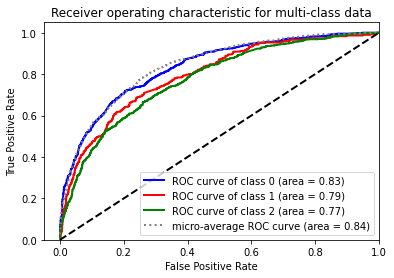

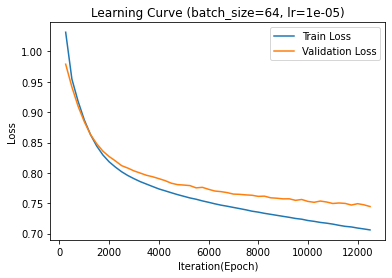

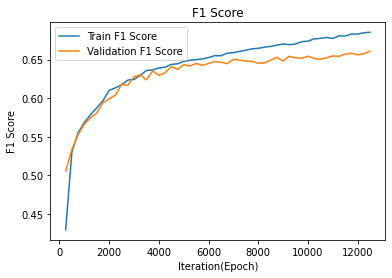

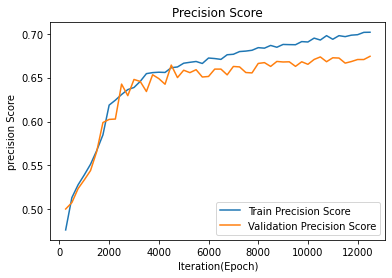

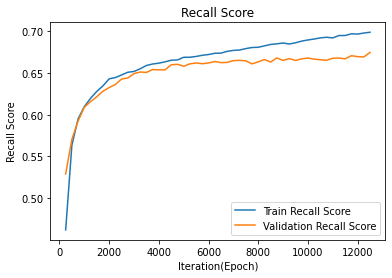

In [ ]:
validation = XVal
validation = validation.unsqueeze(1)
y_pred = model(validation)
# scores = nn.functional.softmax(y_pred, dim=1)
# print(YVal.shape)
# print(y_pred.shape)
fpr0 , tpr0, t0 = roc_curve(YVal.detach().numpy()[:,0],y_pred.detach().numpy()[:,0])
roc_auc0 = auc(fpr0, tpr0)
fpr1 , tpr1, t1 = roc_curve(YVal.detach().numpy()[:,1],y_pred.detach().numpy()[:,1])
roc_auc1 = auc(fpr1, tpr1)
fpr2 , tpr2, t2 = roc_curve(YVal.detach().numpy()[:,2],y_pred.detach().numpy()[:,2])
roc_auc2 = auc(fpr2, tpr2)

fprmicro , tprmicro, tmicro = roc_curve(YVal.ravel().detach().numpy(),y_pred.ravel().detach().numpy())
roc_aucmicro = auc(fprmicro, tprmicro)

# array_fpr = [fpr0,fpr1,fpr2]
# all_fpr = np.unique(np.concatenate([array_fpr[i] for i in range(3)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(3):
#     mean_tpr += np.interp(all_fpr, array_fpr[i], array_fpr[i])

# # Finally average it and compute AUC
# mean_tpr /= 3

# fprmacro = all_fpr
# tprmacro = mean_tpr
# roc_aucmacro = auc(fprmacro, tprmacro)
# print(fprmacro)

plt.plot(fpr0, tpr0, color='blue', lw=2,label='ROC curve of class 0 (area = {0:0.2f})'
''.format(roc_auc0))
plt.plot(fpr1, tpr1, color='red', lw=2,label='ROC curve of class 1 (area = {0:0.2f})'
''.format(roc_auc1))
plt.plot(fpr2, tpr2, color='green', lw=2,label='ROC curve of class 2 (area = {0:0.2f})'
''.format(roc_auc2))
plt.plot(fprmicro, tprmicro,':', color='grey', lw=2,label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_aucmicro))
# plt.plot(fprmacro, tprmacro,'k-.', color='grey', lw=2,label='macro-average ROC curve (area = {0:0.2f})'
# ''.format(roc_aucmacro))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

plt.title("Learning Curve (batch_size={}, lr={})".format(batchSize, learningRate))
plt.plot(iters, losses, label="Train Loss")
plt.plot(iters, losses_Val, label="Validation Loss")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("F1 Score")
plt.plot(iters, f1_train_scores, label="Train F1 Score")
plt.plot(iters, f1_train_scores_Val, label="Validation F1 Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

plt.title("Precision Score")
plt.plot(iters, precision_train_scores, label="Train Precision Score")
plt.plot(iters, precision_train_scores_Val, label="Validation Precision Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("precision Score")
plt.legend(loc='best')
plt.show()

plt.title("Recall Score")
plt.plot(iters, recall_train_scores, label="Train Recall Score")
plt.plot(iters, recall_train_scores_Val, label="Validation Recall Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Recall Score")
plt.legend(loc='best')
plt.show()

# GRU & LSTM RNN Models

## First Model GRU Cells
- Number of Layers 1
- Hidden Size 256
- Glove 300d


Read Files

In [ ]:
#  -- Download GloVe Files --
# n

# file path for glove file
glovePath = "/content/glove.6B.300d.txt"

# # creating dictionary
glove = pd.read_csv(glovePath, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

In [ ]:
from numpy.ma.core import concatenate
# reading the train csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_train_set.csv')
# reading the validation csv
data_Val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_validation_set.csv')

# pre processing the data['tweet']
pre_process(data)
# pre processing the data_Val['tweet']
pre_process(data_Val)

def create_array(tweet):
  return re.split(' ',tweet)

def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in glove_embedding:
      ar = np.zeros([1,300])
    else:
      ar = np.array([glove_embedding.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

# tranform the sentence of words to a 1x50 array using the glove

data['tweet'] = data['tweet'].apply(lambda tweet:create_array(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:transform(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:sum_array(tweet))

data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:create_array(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:transform(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:sum_array(tweet))

# split to variables
XTrain = data['tweet']
XVal = data_Val['tweet']
YTrain = data['label']
YVal = data_Val['label']

In [ ]:
# Train
XTrain = torch.tensor(XTrain,dtype=torch.float)

YTrain = torch.tensor(YTrain,dtype=torch.float)
YTrain = YTrain.to(torch.long)
YTrain = torch.nn.functional.one_hot(YTrain,num_classes=3)
YTrain = YTrain.float()
# Validation
XVal = torch.tensor(XVal,dtype=torch.float)

YVal = torch.tensor(YVal,dtype=torch.float)
YVal = YVal.to(torch.long)
YVal = torch.nn.functional.one_hot(YVal,num_classes=3)
YVal = YVal.float()

print(f"x shape: {XTrain.shape}")
print(XTrain)
print(f"x_Val shape: {XVal.shape}")
print(XVal)
print(f"y shape: {YTrain.shape}")
print(YTrain)
print(f"y_Val shape: {YVal.shape}")
print(YVal)

x shape: torch.Size([15976, 300])
tensor([[-0.4226, -1.1508, -0.0539,  ..., -0.3592,  0.7071, -0.3606],
        [-2.9199,  1.7339, -1.1964,  ..., -3.4243,  0.3180,  1.6826],
        [-0.8554,  1.3731, -2.0530,  ..., -5.0828, -0.4969,  0.5490],
        ...,
        [-1.5591,  0.3572, -0.0653,  ..., -0.5557, -0.3443, -0.5218],
        [-2.2863,  0.7092, -1.5725,  ..., -2.3555, -0.3223, -0.1531],
        [-3.8773,  3.1693, -3.6080,  ..., -4.1248, -0.8857, -0.3447]])
x_Val shape: torch.Size([2282, 300])
tensor([[-5.7583,  5.8541, -1.6753,  ..., -6.0936, -3.3022, -3.2973],
        [-3.5578,  2.1656, -0.6907,  ..., -3.5801, -2.7964, -0.5301],
        [-1.5880,  1.1769, -0.4060,  ..., -1.8123,  0.1574, -0.8568],
        ...,
        [-1.0889,  1.8088, -2.1432,  ..., -2.0436, -0.8788, -0.9485],
        [-2.5667,  0.3689, -0.5168,  ..., -2.0777, -0.3274,  1.1764],
        [-2.7411,  2.0780, -2.3738,  ..., -1.2155, -0.3677,  1.8798]])
y shape: torch.Size([15976, 3])
tensor([[1., 0., 0.],
       

Define RNN Model

In [ ]:
class GRUModel(nn.Module):
  def __init__(self, inputSize, hiddenSize, numLayers, numClasses, dropoutProb):
      super(GRUModel, self).__init__()

      # Defining the number of layers and the nodes in each layer
      self.hiddenSize = hiddenSize
      self.numLayers = numLayers

      # GRU layers
      self.gru = nn.GRU(
          inputSize, hiddenSize, numLayers, batch_first=True, dropout=dropoutProb,bidirectional=False
      )

      # Fully connected layer
      self.fc = nn.Linear(hiddenSize, numClasses)

  def forward(self, x):
      # Initializing hidden state for first input with zeros
      h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)

      # Forward propagation by passing in the input and hidden state into the model
      out, _ = self.gru(x, h0)

      # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
      # so that it can fit into the fully connected layer
      out = out[:, -1, :]

      # Convert the final state to our desired output shape (batch_size, output_dim)
      out = self.fc(out)

      return out

initialize model

In [ ]:
inputSize = XTrain.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50
batchSize = 64

model = GRUModel(inputSize,hiddenSize,numLayers,numClasses,0)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

trainDataset = torch.utils.data.TensorDataset(XTrain, YTrain)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=batchSize,shuffle=True)

valDataset = torch.utils.data.TensorDataset(XVal, YVal)
valLoader = torch.utils.data.DataLoader(dataset=valDataset,batch_size=batchSize,shuffle=True)

GRUModel(
  (gru): GRU(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)


train model

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

totalSteps = len(trainLoader)
n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []
for epoch in range(numEpochs):
    batch_losses,batch_f1_scores,batch_precision_scores,batch_recall_scores = [],[],[],[]
    batch_losses_Val,batch_f1_scores_Val,batch_precision_scores_Val,batch_recall_scores_Val = [],[],[],[]
    for i, (x_batch, y_batch) in enumerate(trainLoader):  

        x_batch = x_batch.unsqueeze(1)

        # Forward pass
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        
        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores.append(f1)
        
        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores.append(recall)
        n_epoch+=1

    for i, (x_batch, y_batch) in enumerate(valLoader):  
        # Val
        x_batch = x_batch.unsqueeze(1)
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)

        batch_losses_Val.append(loss.item())

        # Score
        # scores = nn.functional.softmax(y_pred, dim=1)

        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores_Val.append(f1)

        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores_Val.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores_Val.append(recall)

    iters.append(n_epoch)
    losses.append(sum(batch_losses)/len(trainLoader)) # compute *average* loss
    losses_Val.append(sum(batch_losses_Val)/len(valLoader)) # compute *average* loss

    f1_train_scores.append(sum(batch_f1_scores)/len(trainLoader))
    f1_train_scores_Val.append(sum(batch_f1_scores_Val)/len(valLoader))

    precision_train_scores.append(sum(batch_precision_scores)/len(trainLoader))
    precision_train_scores_Val.append(sum(batch_precision_scores_Val)/len(valLoader))

    recall_train_scores.append(sum(batch_recall_scores)/len(trainLoader))
    recall_train_scores_Val.append(sum(batch_recall_scores_Val)/len(valLoader))

    print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainLoader)} F1 = {sum(batch_f1_scores)/len(trainLoader)} Loss_Val = {sum(batch_losses_Val)/len(valLoader)} F1_Val = {sum(batch_f1_scores_Val)/len(valLoader)}")


Epoch   0: Loss = 0.9954425039291381 F1 = 0.5235494004044393 Loss_Val = 0.9585456136200163 F1_Val = 0.5451872051312471
Epoch   1: Loss = 0.9277898585796356 F1 = 0.5608921326251601 Loss_Val = 0.906970105237431 F1_Val = 0.5536108622569142
Epoch   2: Loss = 0.8796438806056976 F1 = 0.5751001142736397 Loss_Val = 0.8688931779728996 F1_Val = 0.5720274788531005
Epoch   3: Loss = 0.8473155453205109 F1 = 0.5917634953197594 Loss_Val = 0.8447114874919256 F1_Val = 0.5951869838425002
Epoch   4: Loss = 0.8258327701091767 F1 = 0.6095570613983496 Loss_Val = 0.8286786162190967 F1_Val = 0.6072420340801663
Epoch   5: Loss = 0.8105613105297088 F1 = 0.6183875345794788 Loss_Val = 0.8171570830874972 F1_Val = 0.6194306881577838
Epoch   6: Loss = 0.7984491891860962 F1 = 0.6259954259177093 Loss_Val = 0.8072889761792289 F1_Val = 0.6245739515806658
Epoch   7: Loss = 0.7885287961959839 F1 = 0.6309628589285483 Loss_Val = 0.8010126898686091 F1_Val = 0.6334840169177968
Epoch   8: Loss = 0.7801318547725677 F1 = 0.63694

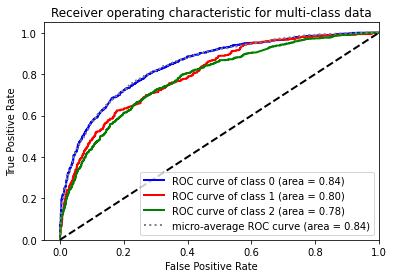

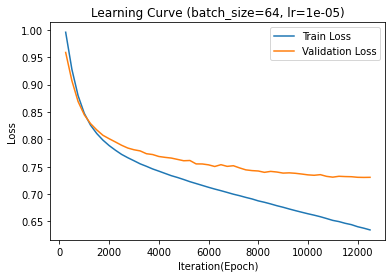

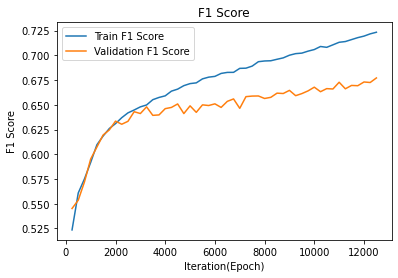

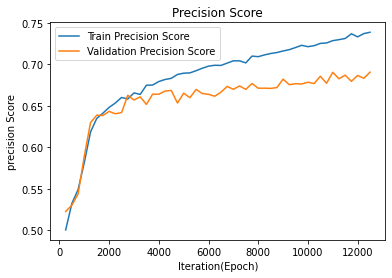

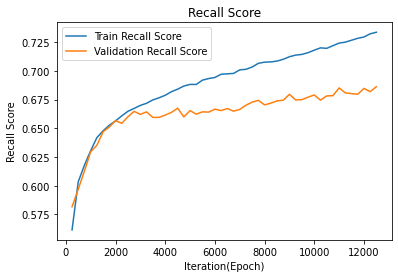

In [ ]:
validation = XVal
validation = validation.unsqueeze(1)
y_pred = model(validation)
# scores = nn.functional.softmax(y_pred, dim=1)
# print(YVal.shape)
# print(y_pred.shape)
fpr0 , tpr0, t0 = roc_curve(YVal.detach().numpy()[:,0],y_pred.detach().numpy()[:,0])
roc_auc0 = auc(fpr0, tpr0)
fpr1 , tpr1, t1 = roc_curve(YVal.detach().numpy()[:,1],y_pred.detach().numpy()[:,1])
roc_auc1 = auc(fpr1, tpr1)
fpr2 , tpr2, t2 = roc_curve(YVal.detach().numpy()[:,2],y_pred.detach().numpy()[:,2])
roc_auc2 = auc(fpr2, tpr2)

fprmicro , tprmicro, tmicro = roc_curve(YVal.ravel().detach().numpy(),y_pred.ravel().detach().numpy())
roc_aucmicro = auc(fprmicro, tprmicro)

# array_fpr = [fpr0,fpr1,fpr2]
# all_fpr = np.unique(np.concatenate([array_fpr[i] for i in range(3)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(3):
#     mean_tpr += np.interp(all_fpr, array_fpr[i], array_fpr[i])

# # Finally average it and compute AUC
# mean_tpr /= 3

# fprmacro = all_fpr
# tprmacro = mean_tpr
# roc_aucmacro = auc(fprmacro, tprmacro)
# print(fprmacro)

plt.plot(fpr0, tpr0, color='blue', lw=2,label='ROC curve of class 0 (area = {0:0.2f})'
''.format(roc_auc0))
plt.plot(fpr1, tpr1, color='red', lw=2,label='ROC curve of class 1 (area = {0:0.2f})'
''.format(roc_auc1))
plt.plot(fpr2, tpr2, color='green', lw=2,label='ROC curve of class 2 (area = {0:0.2f})'
''.format(roc_auc2))
plt.plot(fprmicro, tprmicro,':', color='grey', lw=2,label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_aucmicro))
# plt.plot(fprmacro, tprmacro,'k-.', color='grey', lw=2,label='macro-average ROC curve (area = {0:0.2f})'
# ''.format(roc_aucmacro))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

plt.title("Learning Curve (batch_size={}, lr={})".format(batchSize, learningRate))
plt.plot(iters, losses, label="Train Loss")
plt.plot(iters, losses_Val, label="Validation Loss")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("F1 Score")
plt.plot(iters, f1_train_scores, label="Train F1 Score")
plt.plot(iters, f1_train_scores_Val, label="Validation F1 Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

plt.title("Precision Score")
plt.plot(iters, precision_train_scores, label="Train Precision Score")
plt.plot(iters, precision_train_scores_Val, label="Validation Precision Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("precision Score")
plt.legend(loc='best')
plt.show()

plt.title("Recall Score")
plt.plot(iters, recall_train_scores, label="Train Recall Score")
plt.plot(iters, recall_train_scores_Val, label="Validation Recall Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Recall Score")
plt.legend(loc='best')
plt.show()

## Bidirectional = True


Read Files

In [ ]:
#  -- Download GloVe Files --
# n

# file path for glove file
glovePath = "/content/glove.6B.300d.txt"

# # creating dictionary
glove = pd.read_csv(glovePath, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

In [ ]:
from numpy.ma.core import concatenate
# reading the train csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_train_set.csv')
# reading the validation csv
data_Val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_validation_set.csv')

# pre processing the data['tweet']
pre_process(data)
# pre processing the data_Val['tweet']
pre_process(data_Val)

def create_array(tweet):
  return re.split(' ',tweet)

def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in glove_embedding:
      ar = np.zeros([1,300])
    else:
      ar = np.array([glove_embedding.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

# tranform the sentence of words to a 1x50 array using the glove

data['tweet'] = data['tweet'].apply(lambda tweet:create_array(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:transform(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:sum_array(tweet))

data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:create_array(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:transform(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:sum_array(tweet))

# split to variables
XTrain = data['tweet']
XVal = data_Val['tweet']
YTrain = data['label']
YVal = data_Val['label']

In [ ]:
# Train
XTrain = torch.tensor(XTrain,dtype=torch.float)

YTrain = torch.tensor(YTrain,dtype=torch.float)
YTrain = YTrain.to(torch.long)
YTrain = torch.nn.functional.one_hot(YTrain,num_classes=3)
YTrain = YTrain.float()
# Validation
XVal = torch.tensor(XVal,dtype=torch.float)

YVal = torch.tensor(YVal,dtype=torch.float)
YVal = YVal.to(torch.long)
YVal = torch.nn.functional.one_hot(YVal,num_classes=3)
YVal = YVal.float()

print(f"x shape: {XTrain.shape}")
print(XTrain)
print(f"x_Val shape: {XVal.shape}")
print(XVal)
print(f"y shape: {YTrain.shape}")
print(YTrain)
print(f"y_Val shape: {YVal.shape}")
print(YVal)

x shape: torch.Size([15976, 300])
tensor([[-0.4226, -1.1508, -0.0539,  ..., -0.3592,  0.7071, -0.3606],
        [-2.9199,  1.7339, -1.1964,  ..., -3.4243,  0.3180,  1.6826],
        [-0.8554,  1.3731, -2.0530,  ..., -5.0828, -0.4969,  0.5490],
        ...,
        [-1.5591,  0.3572, -0.0653,  ..., -0.5557, -0.3443, -0.5218],
        [-2.2863,  0.7092, -1.5725,  ..., -2.3555, -0.3223, -0.1531],
        [-3.8773,  3.1693, -3.6080,  ..., -4.1248, -0.8857, -0.3447]])
x_Val shape: torch.Size([2282, 300])
tensor([[-5.7583,  5.8541, -1.6753,  ..., -6.0936, -3.3022, -3.2973],
        [-3.5578,  2.1656, -0.6907,  ..., -3.5801, -2.7964, -0.5301],
        [-1.5880,  1.1769, -0.4060,  ..., -1.8123,  0.1574, -0.8568],
        ...,
        [-1.0889,  1.8088, -2.1432,  ..., -2.0436, -0.8788, -0.9485],
        [-2.5667,  0.3689, -0.5168,  ..., -2.0777, -0.3274,  1.1764],
        [-2.7411,  2.0780, -2.3738,  ..., -1.2155, -0.3677,  1.8798]])
y shape: torch.Size([15976, 3])
tensor([[1., 0., 0.],
       

Define RNN Model

In [ ]:
class GRUModel(nn.Module):
  def __init__(self, inputSize, hiddenSize, numLayers, numClasses, dropoutProb):
      super(GRUModel, self).__init__()

      # Defining the number of layers and the nodes in each layer
      self.hiddenSize = hiddenSize
      self.numLayers = numLayers

      # GRU layers
      self.gru = nn.GRU(
          inputSize, hiddenSize, numLayers, batch_first=True, dropout=dropoutProb,bidirectional=True
      )

      # Fully connected layer
      self.fc = nn.Linear(hiddenSize*2, numClasses)

  def forward(self, x):
      # Initializing hidden state for first input with zeros
      h0 = torch.zeros(self.numLayers*2, x.size(0), self.hiddenSize)

      # Forward propagation by passing in the input and hidden state into the model
      out, _ = self.gru(x, h0)

      # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
      # so that it can fit into the fully connected layer
      out = out[:, -1, :]

      # Convert the final state to our desired output shape (batch_size, output_dim)
      out = self.fc(out)

      return out

initialize model

In [ ]:
inputSize = XTrain.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50
batchSize = 64

model = GRUModel(inputSize,hiddenSize,numLayers,numClasses,0)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

trainDataset = torch.utils.data.TensorDataset(XTrain, YTrain)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=batchSize,shuffle=True)

valDataset = torch.utils.data.TensorDataset(XVal, YVal)
valLoader = torch.utils.data.DataLoader(dataset=valDataset,batch_size=batchSize,shuffle=True)

GRUModel(
  (gru): GRU(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)


train model

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

totalSteps = len(trainLoader)
n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []
for epoch in range(numEpochs):
    batch_losses,batch_f1_scores,batch_precision_scores,batch_recall_scores = [],[],[],[]
    batch_losses_Val,batch_f1_scores_Val,batch_precision_scores_Val,batch_recall_scores_Val = [],[],[],[]
    for i, (x_batch, y_batch) in enumerate(trainLoader):  

        x_batch = x_batch.unsqueeze(1)

        # Forward pass
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        
        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores.append(f1)
        
        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores.append(recall)
        n_epoch+=1

    for i, (x_batch, y_batch) in enumerate(valLoader):  
        # Val
        x_batch = x_batch.unsqueeze(1)
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)

        batch_losses_Val.append(loss.item())

        # Score
        # scores = nn.functional.softmax(y_pred, dim=1)

        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores_Val.append(f1)

        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores_Val.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores_Val.append(recall)

    iters.append(n_epoch)
    losses.append(sum(batch_losses)/len(trainLoader)) # compute *average* loss
    losses_Val.append(sum(batch_losses_Val)/len(valLoader)) # compute *average* loss

    f1_train_scores.append(sum(batch_f1_scores)/len(trainLoader))
    f1_train_scores_Val.append(sum(batch_f1_scores_Val)/len(valLoader))

    precision_train_scores.append(sum(batch_precision_scores)/len(trainLoader))
    precision_train_scores_Val.append(sum(batch_precision_scores_Val)/len(valLoader))

    recall_train_scores.append(sum(batch_recall_scores)/len(trainLoader))
    recall_train_scores_Val.append(sum(batch_recall_scores_Val)/len(valLoader))

    print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainLoader)} F1 = {sum(batch_f1_scores)/len(trainLoader)} Loss_Val = {sum(batch_losses_Val)/len(valLoader)} F1_Val = {sum(batch_f1_scores_Val)/len(valLoader)}")


Epoch   0: Loss = 0.9954425039291381 F1 = 0.5235494004044393 Loss_Val = 0.9585456136200163 F1_Val = 0.5451872051312471
Epoch   1: Loss = 0.9277898585796356 F1 = 0.5608921326251601 Loss_Val = 0.906970105237431 F1_Val = 0.5536108622569142
Epoch   2: Loss = 0.8796438806056976 F1 = 0.5751001142736397 Loss_Val = 0.8688931779728996 F1_Val = 0.5720274788531005
Epoch   3: Loss = 0.8473155453205109 F1 = 0.5917634953197594 Loss_Val = 0.8447114874919256 F1_Val = 0.5951869838425002
Epoch   4: Loss = 0.8258327701091767 F1 = 0.6095570613983496 Loss_Val = 0.8286786162190967 F1_Val = 0.6072420340801663
Epoch   5: Loss = 0.8105613105297088 F1 = 0.6183875345794788 Loss_Val = 0.8171570830874972 F1_Val = 0.6194306881577838
Epoch   6: Loss = 0.7984491891860962 F1 = 0.6259954259177093 Loss_Val = 0.8072889761792289 F1_Val = 0.6245739515806658
Epoch   7: Loss = 0.7885287961959839 F1 = 0.6309628589285483 Loss_Val = 0.8010126898686091 F1_Val = 0.6334840169177968
Epoch   8: Loss = 0.7801318547725677 F1 = 0.63694

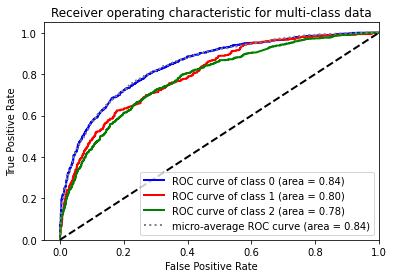

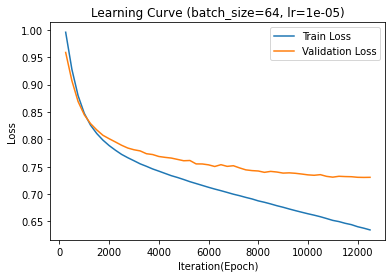

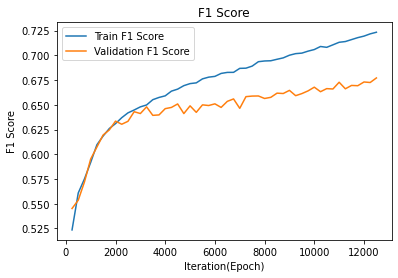

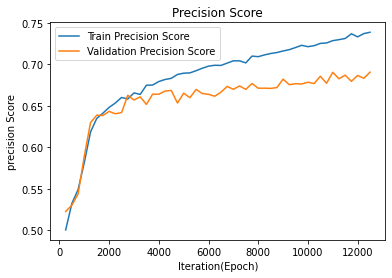

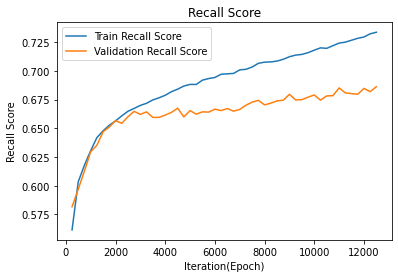

In [ ]:
validation = XVal
validation = validation.unsqueeze(1)
y_pred = model(validation)
# scores = nn.functional.softmax(y_pred, dim=1)
# print(YVal.shape)
# print(y_pred.shape)
fpr0 , tpr0, t0 = roc_curve(YVal.detach().numpy()[:,0],y_pred.detach().numpy()[:,0])
roc_auc0 = auc(fpr0, tpr0)
fpr1 , tpr1, t1 = roc_curve(YVal.detach().numpy()[:,1],y_pred.detach().numpy()[:,1])
roc_auc1 = auc(fpr1, tpr1)
fpr2 , tpr2, t2 = roc_curve(YVal.detach().numpy()[:,2],y_pred.detach().numpy()[:,2])
roc_auc2 = auc(fpr2, tpr2)

fprmicro , tprmicro, tmicro = roc_curve(YVal.ravel().detach().numpy(),y_pred.ravel().detach().numpy())
roc_aucmicro = auc(fprmicro, tprmicro)

# array_fpr = [fpr0,fpr1,fpr2]
# all_fpr = np.unique(np.concatenate([array_fpr[i] for i in range(3)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(3):
#     mean_tpr += np.interp(all_fpr, array_fpr[i], array_fpr[i])

# # Finally average it and compute AUC
# mean_tpr /= 3

# fprmacro = all_fpr
# tprmacro = mean_tpr
# roc_aucmacro = auc(fprmacro, tprmacro)
# print(fprmacro)

plt.plot(fpr0, tpr0, color='blue', lw=2,label='ROC curve of class 0 (area = {0:0.2f})'
''.format(roc_auc0))
plt.plot(fpr1, tpr1, color='red', lw=2,label='ROC curve of class 1 (area = {0:0.2f})'
''.format(roc_auc1))
plt.plot(fpr2, tpr2, color='green', lw=2,label='ROC curve of class 2 (area = {0:0.2f})'
''.format(roc_auc2))
plt.plot(fprmicro, tprmicro,':', color='grey', lw=2,label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_aucmicro))
# plt.plot(fprmacro, tprmacro,'k-.', color='grey', lw=2,label='macro-average ROC curve (area = {0:0.2f})'
# ''.format(roc_aucmacro))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

plt.title("Learning Curve (batch_size={}, lr={})".format(batchSize, learningRate))
plt.plot(iters, losses, label="Train Loss")
plt.plot(iters, losses_Val, label="Validation Loss")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("F1 Score")
plt.plot(iters, f1_train_scores, label="Train F1 Score")
plt.plot(iters, f1_train_scores_Val, label="Validation F1 Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

plt.title("Precision Score")
plt.plot(iters, precision_train_scores, label="Train Precision Score")
plt.plot(iters, precision_train_scores_Val, label="Validation Precision Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("precision Score")
plt.legend(loc='best')
plt.show()

plt.title("Recall Score")
plt.plot(iters, recall_train_scores, label="Train Recall Score")
plt.plot(iters, recall_train_scores_Val, label="Validation Recall Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Recall Score")
plt.legend(loc='best')
plt.show()

## Νumber of layers = 2


Read Files

In [ ]:
#  -- Download GloVe Files --
# n

# file path for glove file
glovePath = "/content/glove.6B.300d.txt"

# # creating dictionary
glove = pd.read_csv(glovePath, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

In [ ]:
from numpy.ma.core import concatenate
# reading the train csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_train_set.csv')
# reading the validation csv
data_Val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_validation_set.csv')

# pre processing the data['tweet']
pre_process(data)
# pre processing the data_Val['tweet']
pre_process(data_Val)

def create_array(tweet):
  return re.split(' ',tweet)

def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in glove_embedding:
      ar = np.zeros([1,300])
    else:
      ar = np.array([glove_embedding.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

# tranform the sentence of words to a 1x50 array using the glove

data['tweet'] = data['tweet'].apply(lambda tweet:create_array(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:transform(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:sum_array(tweet))

data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:create_array(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:transform(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:sum_array(tweet))

# split to variables
XTrain = data['tweet']
XVal = data_Val['tweet']
YTrain = data['label']
YVal = data_Val['label']

In [ ]:
# Train
XTrain = torch.tensor(XTrain,dtype=torch.float)

YTrain = torch.tensor(YTrain,dtype=torch.float)
YTrain = YTrain.to(torch.long)
YTrain = torch.nn.functional.one_hot(YTrain,num_classes=3)
YTrain = YTrain.float()
# Validation
XVal = torch.tensor(XVal,dtype=torch.float)

YVal = torch.tensor(YVal,dtype=torch.float)
YVal = YVal.to(torch.long)
YVal = torch.nn.functional.one_hot(YVal,num_classes=3)
YVal = YVal.float()

print(f"x shape: {XTrain.shape}")
print(XTrain)
print(f"x_Val shape: {XVal.shape}")
print(XVal)
print(f"y shape: {YTrain.shape}")
print(YTrain)
print(f"y_Val shape: {YVal.shape}")
print(YVal)

x shape: torch.Size([15976, 300])
tensor([[-0.4226, -1.1508, -0.0539,  ..., -0.3592,  0.7071, -0.3606],
        [-2.9199,  1.7339, -1.1964,  ..., -3.4243,  0.3180,  1.6826],
        [-0.8554,  1.3731, -2.0530,  ..., -5.0828, -0.4969,  0.5490],
        ...,
        [-1.5591,  0.3572, -0.0653,  ..., -0.5557, -0.3443, -0.5218],
        [-2.2863,  0.7092, -1.5725,  ..., -2.3555, -0.3223, -0.1531],
        [-3.8773,  3.1693, -3.6080,  ..., -4.1248, -0.8857, -0.3447]])
x_Val shape: torch.Size([2282, 300])
tensor([[-5.7583,  5.8541, -1.6753,  ..., -6.0936, -3.3022, -3.2973],
        [-3.5578,  2.1656, -0.6907,  ..., -3.5801, -2.7964, -0.5301],
        [-1.5880,  1.1769, -0.4060,  ..., -1.8123,  0.1574, -0.8568],
        ...,
        [-1.0889,  1.8088, -2.1432,  ..., -2.0436, -0.8788, -0.9485],
        [-2.5667,  0.3689, -0.5168,  ..., -2.0777, -0.3274,  1.1764],
        [-2.7411,  2.0780, -2.3738,  ..., -1.2155, -0.3677,  1.8798]])
y shape: torch.Size([15976, 3])
tensor([[1., 0., 0.],
       

Define RNN Model

In [ ]:
class GRUModel(nn.Module):
  def __init__(self, inputSize, hiddenSize, numLayers, numClasses, dropoutProb):
      super(GRUModel, self).__init__()

      # Defining the number of layers and the nodes in each layer
      self.hiddenSize = hiddenSize
      self.numLayers = numLayers

      # GRU layers
      self.gru = nn.GRU(
          inputSize, hiddenSize, numLayers, batch_first=True, dropout=dropoutProb,bidirectional=True
      )

      # Fully connected layer
      self.fc = nn.Linear(hiddenSize*2, numClasses)

  def forward(self, x):
      # Initializing hidden state for first input with zeros
      h0 = torch.zeros(self.numLayers*2, x.size(0), self.hiddenSize)

      # Forward propagation by passing in the input and hidden state into the model
      out, _ = self.gru(x, h0)

      # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
      # so that it can fit into the fully connected layer
      out = out[:, -1, :]

      # Convert the final state to our desired output shape (batch_size, output_dim)
      out = self.fc(out)

      return out

initialize model

In [ ]:
inputSize = XTrain.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 2
numClasses = 3

learningRate = 0.00001
numEpochs = 50
batchSize = 64

model = GRUModel(inputSize,hiddenSize,numLayers,numClasses,0)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

trainDataset = torch.utils.data.TensorDataset(XTrain, YTrain)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=batchSize,shuffle=True)

valDataset = torch.utils.data.TensorDataset(XVal, YVal)
valLoader = torch.utils.data.DataLoader(dataset=valDataset,batch_size=batchSize,shuffle=True)

GRUModel(
  (gru): GRU(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)


train model

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

totalSteps = len(trainLoader)
n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []
for epoch in range(numEpochs):
    batch_losses,batch_f1_scores,batch_precision_scores,batch_recall_scores = [],[],[],[]
    batch_losses_Val,batch_f1_scores_Val,batch_precision_scores_Val,batch_recall_scores_Val = [],[],[],[]
    for i, (x_batch, y_batch) in enumerate(trainLoader):  

        x_batch = x_batch.unsqueeze(1)

        # Forward pass
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        
        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores.append(f1)
        
        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores.append(recall)
        n_epoch+=1

    for i, (x_batch, y_batch) in enumerate(valLoader):  
        # Val
        x_batch = x_batch.unsqueeze(1)
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)

        batch_losses_Val.append(loss.item())

        # Score
        # scores = nn.functional.softmax(y_pred, dim=1)

        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores_Val.append(f1)

        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores_Val.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores_Val.append(recall)

    iters.append(n_epoch)
    losses.append(sum(batch_losses)/len(trainLoader)) # compute *average* loss
    losses_Val.append(sum(batch_losses_Val)/len(valLoader)) # compute *average* loss

    f1_train_scores.append(sum(batch_f1_scores)/len(trainLoader))
    f1_train_scores_Val.append(sum(batch_f1_scores_Val)/len(valLoader))

    precision_train_scores.append(sum(batch_precision_scores)/len(trainLoader))
    precision_train_scores_Val.append(sum(batch_precision_scores_Val)/len(valLoader))

    recall_train_scores.append(sum(batch_recall_scores)/len(trainLoader))
    recall_train_scores_Val.append(sum(batch_recall_scores_Val)/len(valLoader))

    print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainLoader)} F1 = {sum(batch_f1_scores)/len(trainLoader)} Loss_Val = {sum(batch_losses_Val)/len(valLoader)} F1_Val = {sum(batch_f1_scores_Val)/len(valLoader)}")


Epoch   0: Loss = 0.9954425039291381 F1 = 0.5235494004044393 Loss_Val = 0.9585456136200163 F1_Val = 0.5451872051312471
Epoch   1: Loss = 0.9277898585796356 F1 = 0.5608921326251601 Loss_Val = 0.906970105237431 F1_Val = 0.5536108622569142
Epoch   2: Loss = 0.8796438806056976 F1 = 0.5751001142736397 Loss_Val = 0.8688931779728996 F1_Val = 0.5720274788531005
Epoch   3: Loss = 0.8473155453205109 F1 = 0.5917634953197594 Loss_Val = 0.8447114874919256 F1_Val = 0.5951869838425002
Epoch   4: Loss = 0.8258327701091767 F1 = 0.6095570613983496 Loss_Val = 0.8286786162190967 F1_Val = 0.6072420340801663
Epoch   5: Loss = 0.8105613105297088 F1 = 0.6183875345794788 Loss_Val = 0.8171570830874972 F1_Val = 0.6194306881577838
Epoch   6: Loss = 0.7984491891860962 F1 = 0.6259954259177093 Loss_Val = 0.8072889761792289 F1_Val = 0.6245739515806658
Epoch   7: Loss = 0.7885287961959839 F1 = 0.6309628589285483 Loss_Val = 0.8010126898686091 F1_Val = 0.6334840169177968
Epoch   8: Loss = 0.7801318547725677 F1 = 0.63694

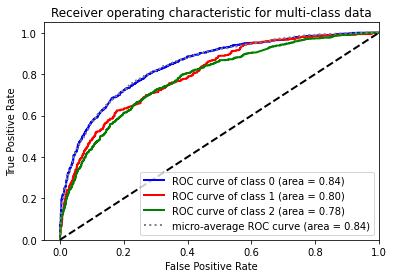

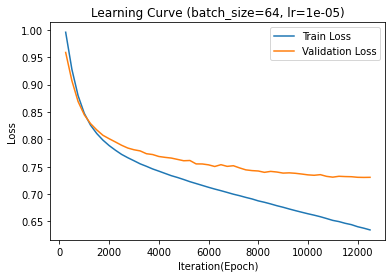

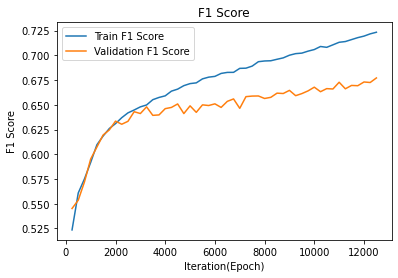

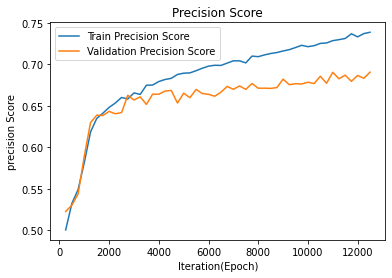

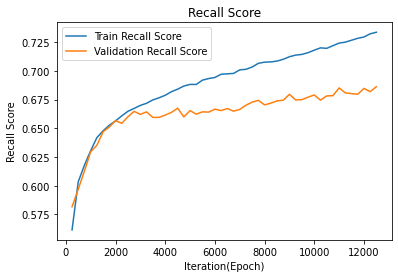

In [ ]:
validation = XVal
validation = validation.unsqueeze(1)
y_pred = model(validation)
# scores = nn.functional.softmax(y_pred, dim=1)
# print(YVal.shape)
# print(y_pred.shape)
fpr0 , tpr0, t0 = roc_curve(YVal.detach().numpy()[:,0],y_pred.detach().numpy()[:,0])
roc_auc0 = auc(fpr0, tpr0)
fpr1 , tpr1, t1 = roc_curve(YVal.detach().numpy()[:,1],y_pred.detach().numpy()[:,1])
roc_auc1 = auc(fpr1, tpr1)
fpr2 , tpr2, t2 = roc_curve(YVal.detach().numpy()[:,2],y_pred.detach().numpy()[:,2])
roc_auc2 = auc(fpr2, tpr2)

fprmicro , tprmicro, tmicro = roc_curve(YVal.ravel().detach().numpy(),y_pred.ravel().detach().numpy())
roc_aucmicro = auc(fprmicro, tprmicro)

# array_fpr = [fpr0,fpr1,fpr2]
# all_fpr = np.unique(np.concatenate([array_fpr[i] for i in range(3)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(3):
#     mean_tpr += np.interp(all_fpr, array_fpr[i], array_fpr[i])

# # Finally average it and compute AUC
# mean_tpr /= 3

# fprmacro = all_fpr
# tprmacro = mean_tpr
# roc_aucmacro = auc(fprmacro, tprmacro)
# print(fprmacro)

plt.plot(fpr0, tpr0, color='blue', lw=2,label='ROC curve of class 0 (area = {0:0.2f})'
''.format(roc_auc0))
plt.plot(fpr1, tpr1, color='red', lw=2,label='ROC curve of class 1 (area = {0:0.2f})'
''.format(roc_auc1))
plt.plot(fpr2, tpr2, color='green', lw=2,label='ROC curve of class 2 (area = {0:0.2f})'
''.format(roc_auc2))
plt.plot(fprmicro, tprmicro,':', color='grey', lw=2,label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_aucmicro))
# plt.plot(fprmacro, tprmacro,'k-.', color='grey', lw=2,label='macro-average ROC curve (area = {0:0.2f})'
# ''.format(roc_aucmacro))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

plt.title("Learning Curve (batch_size={}, lr={})".format(batchSize, learningRate))
plt.plot(iters, losses, label="Train Loss")
plt.plot(iters, losses_Val, label="Validation Loss")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("F1 Score")
plt.plot(iters, f1_train_scores, label="Train F1 Score")
plt.plot(iters, f1_train_scores_Val, label="Validation F1 Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

plt.title("Precision Score")
plt.plot(iters, precision_train_scores, label="Train Precision Score")
plt.plot(iters, precision_train_scores_Val, label="Validation Precision Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("precision Score")
plt.legend(loc='best')
plt.show()

plt.title("Recall Score")
plt.plot(iters, recall_train_scores, label="Train Recall Score")
plt.plot(iters, recall_train_scores_Val, label="Validation Recall Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Recall Score")
plt.legend(loc='best')
plt.show()

## AMSGrad = True


Read Files

In [ ]:
#  -- Download GloVe Files --
# n

# file path for glove file
glovePath = "/content/glove.6B.300d.txt"

# # creating dictionary
glove = pd.read_csv(glovePath, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

In [ ]:
from numpy.ma.core import concatenate
# reading the train csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_train_set.csv')
# reading the validation csv
data_Val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_validation_set.csv')

# pre processing the data['tweet']
pre_process(data)
# pre processing the data_Val['tweet']
pre_process(data_Val)

def create_array(tweet):
  return re.split(' ',tweet)

def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in glove_embedding:
      ar = np.zeros([1,300])
    else:
      ar = np.array([glove_embedding.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

# tranform the sentence of words to a 1x50 array using the glove

data['tweet'] = data['tweet'].apply(lambda tweet:create_array(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:transform(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:sum_array(tweet))

data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:create_array(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:transform(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:sum_array(tweet))

# split to variables
XTrain = data['tweet']
XVal = data_Val['tweet']
YTrain = data['label']
YVal = data_Val['label']

In [ ]:
# Train
XTrain = torch.tensor(XTrain,dtype=torch.float)

YTrain = torch.tensor(YTrain,dtype=torch.float)
YTrain = YTrain.to(torch.long)
YTrain = torch.nn.functional.one_hot(YTrain,num_classes=3)
YTrain = YTrain.float()
# Validation
XVal = torch.tensor(XVal,dtype=torch.float)

YVal = torch.tensor(YVal,dtype=torch.float)
YVal = YVal.to(torch.long)
YVal = torch.nn.functional.one_hot(YVal,num_classes=3)
YVal = YVal.float()

print(f"x shape: {XTrain.shape}")
print(XTrain)
print(f"x_Val shape: {XVal.shape}")
print(XVal)
print(f"y shape: {YTrain.shape}")
print(YTrain)
print(f"y_Val shape: {YVal.shape}")
print(YVal)

x shape: torch.Size([15976, 300])
tensor([[-0.4226, -1.1508, -0.0539,  ..., -0.3592,  0.7071, -0.3606],
        [-2.9199,  1.7339, -1.1964,  ..., -3.4243,  0.3180,  1.6826],
        [-0.8554,  1.3731, -2.0530,  ..., -5.0828, -0.4969,  0.5490],
        ...,
        [-1.5591,  0.3572, -0.0653,  ..., -0.5557, -0.3443, -0.5218],
        [-2.2863,  0.7092, -1.5725,  ..., -2.3555, -0.3223, -0.1531],
        [-3.8773,  3.1693, -3.6080,  ..., -4.1248, -0.8857, -0.3447]])
x_Val shape: torch.Size([2282, 300])
tensor([[-5.7583,  5.8541, -1.6753,  ..., -6.0936, -3.3022, -3.2973],
        [-3.5578,  2.1656, -0.6907,  ..., -3.5801, -2.7964, -0.5301],
        [-1.5880,  1.1769, -0.4060,  ..., -1.8123,  0.1574, -0.8568],
        ...,
        [-1.0889,  1.8088, -2.1432,  ..., -2.0436, -0.8788, -0.9485],
        [-2.5667,  0.3689, -0.5168,  ..., -2.0777, -0.3274,  1.1764],
        [-2.7411,  2.0780, -2.3738,  ..., -1.2155, -0.3677,  1.8798]])
y shape: torch.Size([15976, 3])
tensor([[1., 0., 0.],
       

Define RNN Model

In [ ]:
class GRUModel(nn.Module):
  def __init__(self, inputSize, hiddenSize, numLayers, numClasses, dropoutProb):
      super(GRUModel, self).__init__()

      # Defining the number of layers and the nodes in each layer
      self.hiddenSize = hiddenSize
      self.numLayers = numLayers

      # GRU layers
      self.gru = nn.GRU(
          inputSize, hiddenSize, numLayers, batch_first=True, dropout=dropoutProb,bidirectional=True
      )

      # Fully connected layer
      self.fc = nn.Linear(hiddenSize*2, numClasses)

  def forward(self, x):
      # Initializing hidden state for first input with zeros
      h0 = torch.zeros(self.numLayers*2, x.size(0), self.hiddenSize)

      # Forward propagation by passing in the input and hidden state into the model
      out, _ = self.gru(x, h0)

      # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
      # so that it can fit into the fully connected layer
      out = out[:, -1, :]

      # Convert the final state to our desired output shape (batch_size, output_dim)
      out = self.fc(out)

      return out

initialize model

In [ ]:
inputSize = XTrain.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 2
numClasses = 3

learningRate = 0.00001
numEpochs = 50
batchSize = 64

model = GRUModel(inputSize,hiddenSize,numLayers,numClasses,0)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate,amsgrad=True)

trainDataset = torch.utils.data.TensorDataset(XTrain, YTrain)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=batchSize,shuffle=True)

valDataset = torch.utils.data.TensorDataset(XVal, YVal)
valLoader = torch.utils.data.DataLoader(dataset=valDataset,batch_size=batchSize,shuffle=True)

GRUModel(
  (gru): GRU(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)


train model

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

totalSteps = len(trainLoader)
n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []
for epoch in range(numEpochs):
    batch_losses,batch_f1_scores,batch_precision_scores,batch_recall_scores = [],[],[],[]
    batch_losses_Val,batch_f1_scores_Val,batch_precision_scores_Val,batch_recall_scores_Val = [],[],[],[]
    for i, (x_batch, y_batch) in enumerate(trainLoader):  

        x_batch = x_batch.unsqueeze(1)

        # Forward pass
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        
        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores.append(f1)
        
        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores.append(recall)
        n_epoch+=1

    for i, (x_batch, y_batch) in enumerate(valLoader):  
        # Val
        x_batch = x_batch.unsqueeze(1)
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)

        batch_losses_Val.append(loss.item())

        # Score
        # scores = nn.functional.softmax(y_pred, dim=1)

        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores_Val.append(f1)

        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores_Val.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores_Val.append(recall)

    iters.append(n_epoch)
    losses.append(sum(batch_losses)/len(trainLoader)) # compute *average* loss
    losses_Val.append(sum(batch_losses_Val)/len(valLoader)) # compute *average* loss

    f1_train_scores.append(sum(batch_f1_scores)/len(trainLoader))
    f1_train_scores_Val.append(sum(batch_f1_scores_Val)/len(valLoader))

    precision_train_scores.append(sum(batch_precision_scores)/len(trainLoader))
    precision_train_scores_Val.append(sum(batch_precision_scores_Val)/len(valLoader))

    recall_train_scores.append(sum(batch_recall_scores)/len(trainLoader))
    recall_train_scores_Val.append(sum(batch_recall_scores_Val)/len(valLoader))

    print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainLoader)} F1 = {sum(batch_f1_scores)/len(trainLoader)} Loss_Val = {sum(batch_losses_Val)/len(valLoader)} F1_Val = {sum(batch_f1_scores_Val)/len(valLoader)}")


Epoch   0: Loss = 0.9954425039291381 F1 = 0.5235494004044393 Loss_Val = 0.9585456136200163 F1_Val = 0.5451872051312471
Epoch   1: Loss = 0.9277898585796356 F1 = 0.5608921326251601 Loss_Val = 0.906970105237431 F1_Val = 0.5536108622569142
Epoch   2: Loss = 0.8796438806056976 F1 = 0.5751001142736397 Loss_Val = 0.8688931779728996 F1_Val = 0.5720274788531005
Epoch   3: Loss = 0.8473155453205109 F1 = 0.5917634953197594 Loss_Val = 0.8447114874919256 F1_Val = 0.5951869838425002
Epoch   4: Loss = 0.8258327701091767 F1 = 0.6095570613983496 Loss_Val = 0.8286786162190967 F1_Val = 0.6072420340801663
Epoch   5: Loss = 0.8105613105297088 F1 = 0.6183875345794788 Loss_Val = 0.8171570830874972 F1_Val = 0.6194306881577838
Epoch   6: Loss = 0.7984491891860962 F1 = 0.6259954259177093 Loss_Val = 0.8072889761792289 F1_Val = 0.6245739515806658
Epoch   7: Loss = 0.7885287961959839 F1 = 0.6309628589285483 Loss_Val = 0.8010126898686091 F1_Val = 0.6334840169177968
Epoch   8: Loss = 0.7801318547725677 F1 = 0.63694

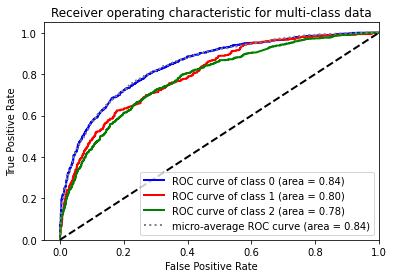

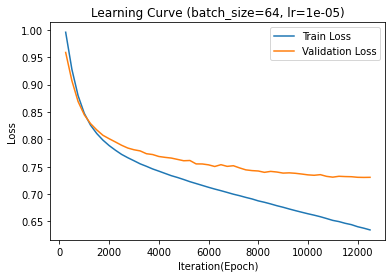

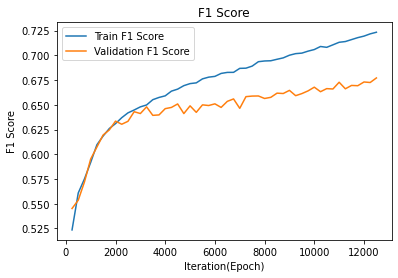

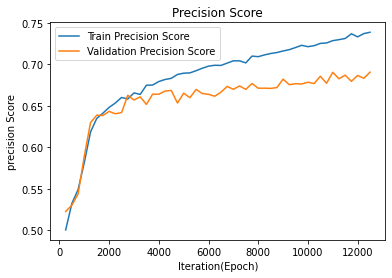

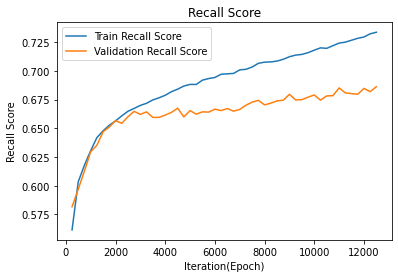

In [ ]:
validation = XVal
validation = validation.unsqueeze(1)
y_pred = model(validation)
# scores = nn.functional.softmax(y_pred, dim=1)
# print(YVal.shape)
# print(y_pred.shape)
fpr0 , tpr0, t0 = roc_curve(YVal.detach().numpy()[:,0],y_pred.detach().numpy()[:,0])
roc_auc0 = auc(fpr0, tpr0)
fpr1 , tpr1, t1 = roc_curve(YVal.detach().numpy()[:,1],y_pred.detach().numpy()[:,1])
roc_auc1 = auc(fpr1, tpr1)
fpr2 , tpr2, t2 = roc_curve(YVal.detach().numpy()[:,2],y_pred.detach().numpy()[:,2])
roc_auc2 = auc(fpr2, tpr2)

fprmicro , tprmicro, tmicro = roc_curve(YVal.ravel().detach().numpy(),y_pred.ravel().detach().numpy())
roc_aucmicro = auc(fprmicro, tprmicro)

# array_fpr = [fpr0,fpr1,fpr2]
# all_fpr = np.unique(np.concatenate([array_fpr[i] for i in range(3)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(3):
#     mean_tpr += np.interp(all_fpr, array_fpr[i], array_fpr[i])

# # Finally average it and compute AUC
# mean_tpr /= 3

# fprmacro = all_fpr
# tprmacro = mean_tpr
# roc_aucmacro = auc(fprmacro, tprmacro)
# print(fprmacro)

plt.plot(fpr0, tpr0, color='blue', lw=2,label='ROC curve of class 0 (area = {0:0.2f})'
''.format(roc_auc0))
plt.plot(fpr1, tpr1, color='red', lw=2,label='ROC curve of class 1 (area = {0:0.2f})'
''.format(roc_auc1))
plt.plot(fpr2, tpr2, color='green', lw=2,label='ROC curve of class 2 (area = {0:0.2f})'
''.format(roc_auc2))
plt.plot(fprmicro, tprmicro,':', color='grey', lw=2,label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_aucmicro))
# plt.plot(fprmacro, tprmacro,'k-.', color='grey', lw=2,label='macro-average ROC curve (area = {0:0.2f})'
# ''.format(roc_aucmacro))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

plt.title("Learning Curve (batch_size={}, lr={})".format(batchSize, learningRate))
plt.plot(iters, losses, label="Train Loss")
plt.plot(iters, losses_Val, label="Validation Loss")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("F1 Score")
plt.plot(iters, f1_train_scores, label="Train F1 Score")
plt.plot(iters, f1_train_scores_Val, label="Validation F1 Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

plt.title("Precision Score")
plt.plot(iters, precision_train_scores, label="Train Precision Score")
plt.plot(iters, precision_train_scores_Val, label="Validation Precision Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("precision Score")
plt.legend(loc='best')
plt.show()

plt.title("Recall Score")
plt.plot(iters, recall_train_scores, label="Train Recall Score")
plt.plot(iters, recall_train_scores_Val, label="Validation Recall Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Recall Score")
plt.legend(loc='best')
plt.show()

## First Model LSTM Cells
- Number of Layers 1
- Hidden Size 256
- Glove 300d
- amsgrad=True


Read Files

In [ ]:
#  -- Download GloVe Files --
# n

# file path for glove file
glovePath = "/content/glove.6B.300d.txt"

# # creating dictionary
glove = pd.read_csv(glovePath, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

In [ ]:
from numpy.ma.core import concatenate
# reading the train csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_train_set.csv')
# reading the validation csv
data_Val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_validation_set.csv')

# pre processing the data['tweet']
pre_process(data)
# pre processing the data_Val['tweet']
pre_process(data_Val)

def create_array(tweet):
  return re.split(' ',tweet)

def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in glove_embedding:
      ar = np.zeros([1,300])
    else:
      ar = np.array([glove_embedding.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

# tranform the sentence of words to a 1x50 array using the glove

data['tweet'] = data['tweet'].apply(lambda tweet:create_array(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:transform(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:sum_array(tweet))

data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:create_array(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:transform(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:sum_array(tweet))

# split to variables
XTrain = data['tweet']
XVal = data_Val['tweet']
YTrain = data['label']
YVal = data_Val['label']

In [ ]:
# Train
XTrain = torch.tensor(XTrain,dtype=torch.float)

YTrain = torch.tensor(YTrain,dtype=torch.float)
YTrain = YTrain.to(torch.long)
YTrain = torch.nn.functional.one_hot(YTrain,num_classes=3)
YTrain = YTrain.float()
# Validation
XVal = torch.tensor(XVal,dtype=torch.float)

YVal = torch.tensor(YVal,dtype=torch.float)
YVal = YVal.to(torch.long)
YVal = torch.nn.functional.one_hot(YVal,num_classes=3)
YVal = YVal.float()

print(f"x shape: {XTrain.shape}")
print(XTrain)
print(f"x_Val shape: {XVal.shape}")
print(XVal)
print(f"y shape: {YTrain.shape}")
print(YTrain)
print(f"y_Val shape: {YVal.shape}")
print(YVal)

x shape: torch.Size([15976, 300])
tensor([[-0.4226, -1.1508, -0.0539,  ..., -0.3592,  0.7071, -0.3606],
        [-2.9199,  1.7339, -1.1964,  ..., -3.4243,  0.3180,  1.6826],
        [-0.8554,  1.3731, -2.0530,  ..., -5.0828, -0.4969,  0.5490],
        ...,
        [-1.5591,  0.3572, -0.0653,  ..., -0.5557, -0.3443, -0.5218],
        [-2.2863,  0.7092, -1.5725,  ..., -2.3555, -0.3223, -0.1531],
        [-3.8773,  3.1693, -3.6080,  ..., -4.1248, -0.8857, -0.3447]])
x_Val shape: torch.Size([2282, 300])
tensor([[-5.7583,  5.8541, -1.6753,  ..., -6.0936, -3.3022, -3.2973],
        [-3.5578,  2.1656, -0.6907,  ..., -3.5801, -2.7964, -0.5301],
        [-1.5880,  1.1769, -0.4060,  ..., -1.8123,  0.1574, -0.8568],
        ...,
        [-1.0889,  1.8088, -2.1432,  ..., -2.0436, -0.8788, -0.9485],
        [-2.5667,  0.3689, -0.5168,  ..., -2.0777, -0.3274,  1.1764],
        [-2.7411,  2.0780, -2.3738,  ..., -1.2155, -0.3677,  1.8798]])
y shape: torch.Size([15976, 3])
tensor([[1., 0., 0.],
       

Define RNN Model

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, inputSize, hiddenSize, numLayers, numClasses, dropoutProb):
      super(LSTMModel, self).__init__()

 # Defining the number of layers and the nodes in each layer
      self.hiddenSize = hiddenSize
      self.numLayers = numLayers

      # LSTM layers
      self.lstm = nn.LSTM(inputSize, hiddenSize, numLayers, batch_first=True, dropout=dropoutProb,bidirectional = False)

      # Fully connected layer
      self.fc = nn.Linear(hiddenSize, numClasses)

  def forward(self, x):
      # Initializing hidden state for first input with zeros
      h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    
      # Initializing cell state for first input with zeros
      c0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)

      # We need to detach as we are doing truncated backpropagation through time (BPTT)
      # If we don't, we'll backprop all the way to the start even after going through another batch
      # Forward propagation by passing in the input, hidden state, and cell state into the model
      out, (hn, cn) = self.lstm(x, (h0, c0))

      # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
      # so that it can fit into the fully connected layer
      out = out[:, -1, :]

      # Convert the final state to our desired output shape (batch_size, output_dim)
      out = self.fc(out)

      return out

initialize model

In [ ]:
inputSize = XTrain.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50
batchSize = 64

model = LSTMModel(inputSize,hiddenSize,numLayers,numClasses,0)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate,amsgrad=True)

trainDataset = torch.utils.data.TensorDataset(XTrain, YTrain)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=batchSize,shuffle=True)

valDataset = torch.utils.data.TensorDataset(XVal, YVal)
valLoader = torch.utils.data.DataLoader(dataset=valDataset,batch_size=batchSize,shuffle=True)

LSTMModel(
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)


train model

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

totalSteps = len(trainLoader)
n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []
for epoch in range(numEpochs):
    batch_losses,batch_f1_scores,batch_precision_scores,batch_recall_scores = [],[],[],[]
    batch_losses_Val,batch_f1_scores_Val,batch_precision_scores_Val,batch_recall_scores_Val = [],[],[],[]
    for i, (x_batch, y_batch) in enumerate(trainLoader):  

        x_batch = x_batch.unsqueeze(1)

        # Forward pass
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        
        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores.append(f1)
        
        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores.append(recall)
        n_epoch+=1

    for i, (x_batch, y_batch) in enumerate(valLoader):  
        # Val
        x_batch = x_batch.unsqueeze(1)
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)

        batch_losses_Val.append(loss.item())

        # Score
        # scores = nn.functional.softmax(y_pred, dim=1)

        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores_Val.append(f1)

        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores_Val.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores_Val.append(recall)

    iters.append(n_epoch)
    losses.append(sum(batch_losses)/len(trainLoader)) # compute *average* loss
    losses_Val.append(sum(batch_losses_Val)/len(valLoader)) # compute *average* loss

    f1_train_scores.append(sum(batch_f1_scores)/len(trainLoader))
    f1_train_scores_Val.append(sum(batch_f1_scores_Val)/len(valLoader))

    precision_train_scores.append(sum(batch_precision_scores)/len(trainLoader))
    precision_train_scores_Val.append(sum(batch_precision_scores_Val)/len(valLoader))

    recall_train_scores.append(sum(batch_recall_scores)/len(trainLoader))
    recall_train_scores_Val.append(sum(batch_recall_scores_Val)/len(valLoader))

    print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainLoader)} F1 = {sum(batch_f1_scores)/len(trainLoader)} Loss_Val = {sum(batch_losses_Val)/len(valLoader)} F1_Val = {sum(batch_f1_scores_Val)/len(valLoader)}")


KeyboardInterrupt: ignored

In [ ]:
validation = XVal
validation = validation.unsqueeze(1)
y_pred = model(validation)
# scores = nn.functional.softmax(y_pred, dim=1)
# print(YVal.shape)
# print(y_pred.shape)
fpr0 , tpr0, t0 = roc_curve(YVal.detach().numpy()[:,0],y_pred.detach().numpy()[:,0])
roc_auc0 = auc(fpr0, tpr0)
fpr1 , tpr1, t1 = roc_curve(YVal.detach().numpy()[:,1],y_pred.detach().numpy()[:,1])
roc_auc1 = auc(fpr1, tpr1)
fpr2 , tpr2, t2 = roc_curve(YVal.detach().numpy()[:,2],y_pred.detach().numpy()[:,2])
roc_auc2 = auc(fpr2, tpr2)

fprmicro , tprmicro, tmicro = roc_curve(YVal.ravel().detach().numpy(),y_pred.ravel().detach().numpy())
roc_aucmicro = auc(fprmicro, tprmicro)

# array_fpr = [fpr0,fpr1,fpr2]
# all_fpr = np.unique(np.concatenate([array_fpr[i] for i in range(3)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(3):
#     mean_tpr += np.interp(all_fpr, array_fpr[i], array_fpr[i])

# # Finally average it and compute AUC
# mean_tpr /= 3

# fprmacro = all_fpr
# tprmacro = mean_tpr
# roc_aucmacro = auc(fprmacro, tprmacro)
# print(fprmacro)

plt.plot(fpr0, tpr0, color='blue', lw=2,label='ROC curve of class 0 (area = {0:0.2f})'
''.format(roc_auc0))
plt.plot(fpr1, tpr1, color='red', lw=2,label='ROC curve of class 1 (area = {0:0.2f})'
''.format(roc_auc1))
plt.plot(fpr2, tpr2, color='green', lw=2,label='ROC curve of class 2 (area = {0:0.2f})'
''.format(roc_auc2))
plt.plot(fprmicro, tprmicro,':', color='grey', lw=2,label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_aucmicro))
# plt.plot(fprmacro, tprmacro,'k-.', color='grey', lw=2,label='macro-average ROC curve (area = {0:0.2f})'
# ''.format(roc_aucmacro))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

plt.title("Learning Curve (batch_size={}, lr={})".format(batchSize, learningRate))
plt.plot(iters, losses, label="Train Loss")
plt.plot(iters, losses_Val, label="Validation Loss")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("F1 Score")
plt.plot(iters, f1_train_scores, label="Train F1 Score")
plt.plot(iters, f1_train_scores_Val, label="Validation F1 Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

plt.title("Precision Score")
plt.plot(iters, precision_train_scores, label="Train Precision Score")
plt.plot(iters, precision_train_scores_Val, label="Validation Precision Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("precision Score")
plt.legend(loc='best')
plt.show()

plt.title("Recall Score")
plt.plot(iters, recall_train_scores, label="Train Recall Score")
plt.plot(iters, recall_train_scores_Val, label="Validation Recall Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Recall Score")
plt.legend(loc='best')
plt.show()

## Bidirectional = True, Νumber of Layers = 2, Dropout Propability = 0.2

Read Files

In [ ]:
#  -- Download GloVe Files --
# n

# file path for glove file
glovePath = "/content/glove.6B.300d.txt"

# # creating dictionary
glove = pd.read_csv(glovePath, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

In [ ]:
from numpy.ma.core import concatenate
# reading the train csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_train_set.csv')
# reading the validation csv
data_Val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_validation_set.csv')

# pre processing the data['tweet']
pre_process(data)
# pre processing the data_Val['tweet']
pre_process(data_Val)

def create_array(tweet):
  return re.split(' ',tweet)

def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in glove_embedding:
      ar = np.zeros([1,300])
    else:
      ar = np.array([glove_embedding.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

# tranform the sentence of words to a 1x50 array using the glove

data['tweet'] = data['tweet'].apply(lambda tweet:create_array(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:transform(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:sum_array(tweet))

data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:create_array(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:transform(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:sum_array(tweet))

# split to variables
XTrain = data['tweet']
XVal = data_Val['tweet']
YTrain = data['label']
YVal = data_Val['label']

In [ ]:
# Train
XTrain = torch.tensor(XTrain,dtype=torch.float)

YTrain = torch.tensor(YTrain,dtype=torch.float)
YTrain = YTrain.to(torch.long)
YTrain = torch.nn.functional.one_hot(YTrain,num_classes=3)
YTrain = YTrain.float()
# Validation
XVal = torch.tensor(XVal,dtype=torch.float)

YVal = torch.tensor(YVal,dtype=torch.float)
YVal = YVal.to(torch.long)
YVal = torch.nn.functional.one_hot(YVal,num_classes=3)
YVal = YVal.float()

print(f"x shape: {XTrain.shape}")
print(XTrain)
print(f"x_Val shape: {XVal.shape}")
print(XVal)
print(f"y shape: {YTrain.shape}")
print(YTrain)
print(f"y_Val shape: {YVal.shape}")
print(YVal)

x shape: torch.Size([15976, 300])
tensor([[-0.4226, -1.1508, -0.0539,  ..., -0.3592,  0.7071, -0.3606],
        [-2.9199,  1.7339, -1.1964,  ..., -3.4243,  0.3180,  1.6826],
        [-0.8554,  1.3731, -2.0530,  ..., -5.0828, -0.4969,  0.5490],
        ...,
        [-1.5591,  0.3572, -0.0653,  ..., -0.5557, -0.3443, -0.5218],
        [-2.2863,  0.7092, -1.5725,  ..., -2.3555, -0.3223, -0.1531],
        [-3.8773,  3.1693, -3.6080,  ..., -4.1248, -0.8857, -0.3447]])
x_Val shape: torch.Size([2282, 300])
tensor([[-5.7583,  5.8541, -1.6753,  ..., -6.0936, -3.3022, -3.2973],
        [-3.5578,  2.1656, -0.6907,  ..., -3.5801, -2.7964, -0.5301],
        [-1.5880,  1.1769, -0.4060,  ..., -1.8123,  0.1574, -0.8568],
        ...,
        [-1.0889,  1.8088, -2.1432,  ..., -2.0436, -0.8788, -0.9485],
        [-2.5667,  0.3689, -0.5168,  ..., -2.0777, -0.3274,  1.1764],
        [-2.7411,  2.0780, -2.3738,  ..., -1.2155, -0.3677,  1.8798]])
y shape: torch.Size([15976, 3])
tensor([[1., 0., 0.],
       

Define RNN Model

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, inputSize, hiddenSize, numLayers, numClasses, dropoutProb):
      super(LSTMModel, self).__init__()

 # Defining the number of layers and the nodes in each layer
      self.hiddenSize = hiddenSize
      self.numLayers = numLayers

      # LSTM layers
      self.lstm = nn.LSTM(inputSize, hiddenSize, numLayers, batch_first=True, dropout=dropoutProb,bidirectional = True)

      # Fully connected layer
      self.fc = nn.Linear(hiddenSize*2, numClasses)

  def forward(self, x):
      # Initializing hidden state for first input with zeros
      h0 = torch.zeros(self.numLayers*2, x.size(0), self.hiddenSize)
    
      # Initializing cell state for first input with zeros
      c0 = torch.zeros(self.numLayers*2, x.size(0), self.hiddenSize)

      # We need to detach as we are doing truncated backpropagation through time (BPTT)
      # If we don't, we'll backprop all the way to the start even after going through another batch
      # Forward propagation by passing in the input, hidden state, and cell state into the model
      out, (hn, cn) = self.lstm(x, (h0, c0))

      # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
      # so that it can fit into the fully connected layer
      out = out[:, -1, :]

      # Convert the final state to our desired output shape (batch_size, output_dim)
      out = self.fc(out)

      return out

initialize model

In [ ]:
inputSize = XTrain.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 2
numClasses = 3

learningRate = 0.00001
numEpochs = 50
batchSize = 64

model = LSTMModel(inputSize,hiddenSize,numLayers,numClasses,0.2)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate,amsgrad=True)

trainDataset = torch.utils.data.TensorDataset(XTrain, YTrain)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=batchSize,shuffle=True)

valDataset = torch.utils.data.TensorDataset(XVal, YVal)
valLoader = torch.utils.data.DataLoader(dataset=valDataset,batch_size=batchSize,shuffle=True)

LSTMModel(
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)


train model

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

totalSteps = len(trainLoader)
n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []
for epoch in range(numEpochs):
    batch_losses,batch_f1_scores,batch_precision_scores,batch_recall_scores = [],[],[],[]
    batch_losses_Val,batch_f1_scores_Val,batch_precision_scores_Val,batch_recall_scores_Val = [],[],[],[]
    for i, (x_batch, y_batch) in enumerate(trainLoader):  

        x_batch = x_batch.unsqueeze(1)

        # Forward pass
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        
        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores.append(f1)
        
        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores.append(recall)
        n_epoch+=1

    for i, (x_batch, y_batch) in enumerate(valLoader):  
        # Val
        x_batch = x_batch.unsqueeze(1)
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)

        batch_losses_Val.append(loss.item())

        # Score
        # scores = nn.functional.softmax(y_pred, dim=1)

        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores_Val.append(f1)

        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores_Val.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores_Val.append(recall)

    iters.append(n_epoch)
    losses.append(sum(batch_losses)/len(trainLoader)) # compute *average* loss
    losses_Val.append(sum(batch_losses_Val)/len(valLoader)) # compute *average* loss

    f1_train_scores.append(sum(batch_f1_scores)/len(trainLoader))
    f1_train_scores_Val.append(sum(batch_f1_scores_Val)/len(valLoader))

    precision_train_scores.append(sum(batch_precision_scores)/len(trainLoader))
    precision_train_scores_Val.append(sum(batch_precision_scores_Val)/len(valLoader))

    recall_train_scores.append(sum(batch_recall_scores)/len(trainLoader))
    recall_train_scores_Val.append(sum(batch_recall_scores_Val)/len(valLoader))

    print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainLoader)} F1 = {sum(batch_f1_scores)/len(trainLoader)} Loss_Val = {sum(batch_losses_Val)/len(valLoader)} F1_Val = {sum(batch_f1_scores_Val)/len(valLoader)}")


Epoch   0: Loss = 1.042018095254898 F1 = 0.3530317525170738 Loss_Val = 1.0057608385880787 F1_Val = 0.49774949750726694
Epoch   1: Loss = 0.9803098061084747 F1 = 0.5283987158889242 Loss_Val = 0.9629578275812997 F1_Val = 0.5176534415166396
Epoch   2: Loss = 0.9345666844844818 F1 = 0.5479784514908529 Loss_Val = 0.9193628463480208 F1_Val = 0.5322881972603709
Epoch   3: Loss = 0.8953508546352387 F1 = 0.5557586566906891 Loss_Val = 0.8877524766657088 F1_Val = 0.5517620548207062
Epoch   4: Loss = 0.8655665986537934 F1 = 0.5772800630069032 Loss_Val = 0.8639644599623151 F1_Val = 0.5738398086276617
Epoch   5: Loss = 0.8446094665527344 F1 = 0.5851183505259389 Loss_Val = 0.8458029727141062 F1_Val = 0.5890699951829794
Epoch   6: Loss = 0.830567524433136 F1 = 0.5969309039989305 Loss_Val = 0.8367756654818853 F1_Val = 0.5902110029748309
Epoch   7: Loss = 0.8185901234149933 F1 = 0.6054383079670934 Loss_Val = 0.8297890573740005 F1_Val = 0.5945599114703888
Epoch   8: Loss = 0.8100055267810822 F1 = 0.61334

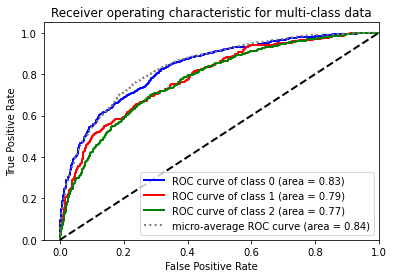

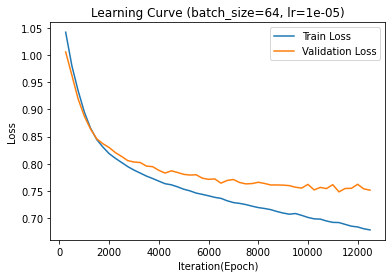

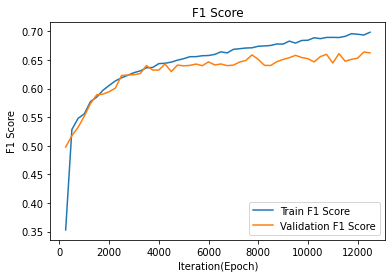

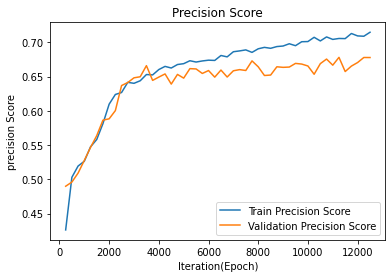

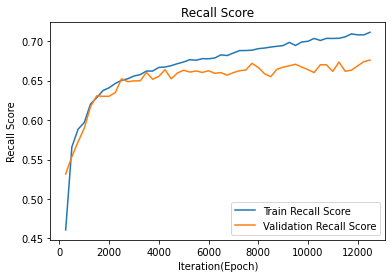

In [ ]:
validation = XVal
validation = validation.unsqueeze(1)
y_pred = model(validation)
# scores = nn.functional.softmax(y_pred, dim=1)
# print(YVal.shape)
# print(y_pred.shape)
fpr0 , tpr0, t0 = roc_curve(YVal.detach().numpy()[:,0],y_pred.detach().numpy()[:,0])
roc_auc0 = auc(fpr0, tpr0)
fpr1 , tpr1, t1 = roc_curve(YVal.detach().numpy()[:,1],y_pred.detach().numpy()[:,1])
roc_auc1 = auc(fpr1, tpr1)
fpr2 , tpr2, t2 = roc_curve(YVal.detach().numpy()[:,2],y_pred.detach().numpy()[:,2])
roc_auc2 = auc(fpr2, tpr2)

fprmicro , tprmicro, tmicro = roc_curve(YVal.ravel().detach().numpy(),y_pred.ravel().detach().numpy())
roc_aucmicro = auc(fprmicro, tprmicro)

# array_fpr = [fpr0,fpr1,fpr2]
# all_fpr = np.unique(np.concatenate([array_fpr[i] for i in range(3)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(3):
#     mean_tpr += np.interp(all_fpr, array_fpr[i], array_fpr[i])

# # Finally average it and compute AUC
# mean_tpr /= 3

# fprmacro = all_fpr
# tprmacro = mean_tpr
# roc_aucmacro = auc(fprmacro, tprmacro)
# print(fprmacro)

plt.plot(fpr0, tpr0, color='blue', lw=2,label='ROC curve of class 0 (area = {0:0.2f})'
''.format(roc_auc0))
plt.plot(fpr1, tpr1, color='red', lw=2,label='ROC curve of class 1 (area = {0:0.2f})'
''.format(roc_auc1))
plt.plot(fpr2, tpr2, color='green', lw=2,label='ROC curve of class 2 (area = {0:0.2f})'
''.format(roc_auc2))
plt.plot(fprmicro, tprmicro,':', color='grey', lw=2,label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_aucmicro))
# plt.plot(fprmacro, tprmacro,'k-.', color='grey', lw=2,label='macro-average ROC curve (area = {0:0.2f})'
# ''.format(roc_aucmacro))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

plt.title("Learning Curve (batch_size={}, lr={})".format(batchSize, learningRate))
plt.plot(iters, losses, label="Train Loss")
plt.plot(iters, losses_Val, label="Validation Loss")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("F1 Score")
plt.plot(iters, f1_train_scores, label="Train F1 Score")
plt.plot(iters, f1_train_scores_Val, label="Validation F1 Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

plt.title("Precision Score")
plt.plot(iters, precision_train_scores, label="Train Precision Score")
plt.plot(iters, precision_train_scores_Val, label="Validation Precision Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("precision Score")
plt.legend(loc='best')
plt.show()

plt.title("Recall Score")
plt.plot(iters, recall_train_scores, label="Train Recall Score")
plt.plot(iters, recall_train_scores_Val, label="Validation Recall Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Recall Score")
plt.legend(loc='best')
plt.show()

# Best Model

Read Files

In [ ]:
#  -- Download GloVe Files --
# n

# file path for glove file
glovePath = "/content/glove.6B.300d.tx  t"

# # creating dictionary
glove = pd.read_csv(glovePath, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

In [ ]:
from numpy.ma.core import concatenate
# reading the train csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_train_set.csv')
# reading the validation csv
data_Val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataSets/vaccine_validation_set.csv')

# pre processing the data['tweet']
pre_process(data)
# pre processing the data_Val['tweet']
pre_process(data_Val)

def create_array(tweet):
  return re.split(' ',tweet)

def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in glove_embedding:
      ar = np.zeros([1,300])
    else:
      ar = np.array([glove_embedding.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

# tranform the sentence of words to a 1x50 array using the glove

data['tweet'] = data['tweet'].apply(lambda tweet:create_array(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:transform(tweet))
data['tweet'] = data['tweet'].apply(lambda tweet:sum_array(tweet))

data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:create_array(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:transform(tweet))
data_Val['tweet'] = data_Val['tweet'].apply(lambda tweet:sum_array(tweet))

# split to variables
XTrain = data['tweet']
XVal = data_Val['tweet']
YTrain = data['label']
YVal = data_Val['label']

In [ ]:
# Train
XTrain = torch.tensor(XTrain,dtype=torch.float)

YTrain = torch.tensor(YTrain,dtype=torch.float)
YTrain = YTrain.to(torch.long)
YTrain = torch.nn.functional.one_hot(YTrain,num_classes=3)
YTrain = YTrain.float()
# Validation
XVal = torch.tensor(XVal,dtype=torch.float)

YVal = torch.tensor(YVal,dtype=torch.float)
YVal = YVal.to(torch.long)
YVal = torch.nn.functional.one_hot(YVal,num_classes=3)
YVal = YVal.float()

print(f"x shape: {XTrain.shape}")
print(XTrain)
print(f"x_Val shape: {XVal.shape}")
print(XVal)
print(f"y shape: {YTrain.shape}")
print(YTrain)
print(f"y_Val shape: {YVal.shape}")
print(YVal)

x shape: torch.Size([15976, 300])
tensor([[-0.4226, -1.1508, -0.0539,  ..., -0.3592,  0.7071, -0.3606],
        [-2.9199,  1.7339, -1.1964,  ..., -3.4243,  0.3180,  1.6826],
        [-0.8554,  1.3731, -2.0530,  ..., -5.0828, -0.4969,  0.5490],
        ...,
        [-1.5591,  0.3572, -0.0653,  ..., -0.5557, -0.3443, -0.5218],
        [-2.2863,  0.7092, -1.5725,  ..., -2.3555, -0.3223, -0.1531],
        [-3.8773,  3.1693, -3.6080,  ..., -4.1248, -0.8857, -0.3447]])
x_Val shape: torch.Size([2282, 300])
tensor([[-5.7583,  5.8541, -1.6753,  ..., -6.0936, -3.3022, -3.2973],
        [-3.5578,  2.1656, -0.6907,  ..., -3.5801, -2.7964, -0.5301],
        [-1.5880,  1.1769, -0.4060,  ..., -1.8123,  0.1574, -0.8568],
        ...,
        [-1.0889,  1.8088, -2.1432,  ..., -2.0436, -0.8788, -0.9485],
        [-2.5667,  0.3689, -0.5168,  ..., -2.0777, -0.3274,  1.1764],
        [-2.7411,  2.0780, -2.3738,  ..., -1.2155, -0.3677,  1.8798]])
y shape: torch.Size([15976, 3])
tensor([[1., 0., 0.],
       

Define RNN Model

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, inputSize, hiddenSize, numLayers, numClasses, dropoutProb):
      super(LSTMModel, self).__init__()

 # Defining the number of layers and the nodes in each layer
      self.hiddenSize = hiddenSize
      self.numLayers = numLayers

      # LSTM layers
      self.lstm = nn.LSTM(inputSize, hiddenSize, numLayers, batch_first=True, dropout=dropoutProb,bidirectional = False)

      # Fully connected layer
      self.fc = nn.Linear(hiddenSize, numClasses)

  def forward(self, x):
      # Initializing hidden state for first input with zeros
      h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    
      # Initializing cell state for first input with zeros
      c0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)

      # We need to detach as we are doing truncated backpropagation through time (BPTT)
      # If we don't, we'll backprop all the way to the start even after going through another batch
      # Forward propagation by passing in the input, hidden state, and cell state into the model
      out, (hn, cn) = self.lstm(x, (h0, c0))

      # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
      # so that it can fit into the fully connected layer
      out = out[:, -1, :]

      # Convert the final state to our desired output shape (batch_size, output_dim)
      out = self.fc(out)

      return out

initialize model

In [ ]:
inputSize = XTrain.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50
batchSize = 64

model = LSTMModel(inputSize,hiddenSize,numLayers,numClasses,0)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate,amsgrad=True)

trainDataset = torch.utils.data.TensorDataset(XTrain, YTrain)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=batchSize,shuffle=True)

valDataset = torch.utils.data.TensorDataset(XVal, YVal)
valLoader = torch.utils.data.DataLoader(dataset=valDataset,batch_size=batchSize,shuffle=True)

LSTMModel(
  (lstm): LSTM(300, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


train model

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

totalSteps = len(trainLoader)
n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []
for epoch in range(numEpochs):
    batch_losses,batch_f1_scores,batch_precision_scores,batch_recall_scores = [],[],[],[]
    batch_losses_Val,batch_f1_scores_Val,batch_precision_scores_Val,batch_recall_scores_Val = [],[],[],[]
    for i, (x_batch, y_batch) in enumerate(trainLoader):  

        x_batch = x_batch.unsqueeze(1)

        # Forward pass
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        
        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores.append(f1)
        
        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores.append(recall)
        n_epoch+=1

    for i, (x_batch, y_batch) in enumerate(valLoader):  
        # Val
        x_batch = x_batch.unsqueeze(1)
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)

        batch_losses_Val.append(loss.item())

        # Score
        # scores = nn.functional.softmax(y_pred, dim=1)

        output =  torch.argmax(y_pred, dim=1)
        answer = torch.argmax(y_batch, dim=1)

        f1 = f1_score(answer,output,average='weighted')
        batch_f1_scores_Val.append(f1)

        precision = precision_score(answer,output,average='weighted',zero_division=0)
        batch_precision_scores_Val.append(precision)

        recall = recall_score(answer,output,average='weighted',zero_division=0)
        batch_recall_scores_Val.append(recall)

    iters.append(n_epoch)
    losses.append(sum(batch_losses)/len(trainLoader)) # compute *average* loss
    losses_Val.append(sum(batch_losses_Val)/len(valLoader)) # compute *average* loss

    f1_train_scores.append(sum(batch_f1_scores)/len(trainLoader))
    f1_train_scores_Val.append(sum(batch_f1_scores_Val)/len(valLoader))

    precision_train_scores.append(sum(batch_precision_scores)/len(trainLoader))
    precision_train_scores_Val.append(sum(batch_precision_scores_Val)/len(valLoader))

    recall_train_scores.append(sum(batch_recall_scores)/len(trainLoader))
    recall_train_scores_Val.append(sum(batch_recall_scores_Val)/len(valLoader))

    print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainLoader)} F1 = {sum(batch_f1_scores)/len(trainLoader)} Loss_Val = {sum(batch_losses_Val)/len(valLoader)} F1_Val = {sum(batch_f1_scores_Val)/len(valLoader)}")


Epoch   0: Loss = 1.0535874032974244 F1 = 0.4325943322106377 Loss_Val = 1.008231262365977 F1_Val = 0.510265456970441
Epoch   1: Loss = 0.9856288788318635 F1 = 0.539644352385284 Loss_Val = 0.9691963195800781 F1_Val = 0.530952105021814
Epoch   2: Loss = 0.951703316450119 F1 = 0.5532100247279679 Loss_Val = 0.9417052931255765 F1_Val = 0.5481167958563101
Epoch   3: Loss = 0.9252969915866852 F1 = 0.5618410441948167 Loss_Val = 0.9182674735784531 F1_Val = 0.5542005986498982
Epoch   4: Loss = 0.9032716522216797 F1 = 0.5694341316107535 Loss_Val = 0.8998900370465385 F1_Val = 0.5666957221576242
Epoch   5: Loss = 0.8849689040184021 F1 = 0.5775082353213501 Loss_Val = 0.8831750684314303 F1_Val = 0.5729987676147684
Epoch   6: Loss = 0.8700117983818054 F1 = 0.5839937707932011 Loss_Val = 0.8700144423378838 F1_Val = 0.5854690230759593
Epoch   7: Loss = 0.857339791059494 F1 = 0.590588243190364 Loss_Val = 0.8593653440475464 F1_Val = 0.5875666158881857
Epoch   8: Loss = 0.8468023207187653 F1 = 0.59511148025

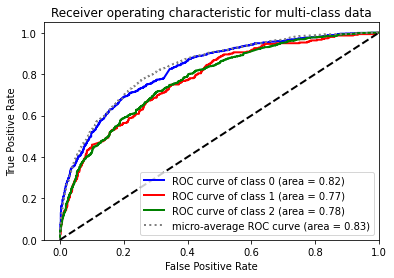

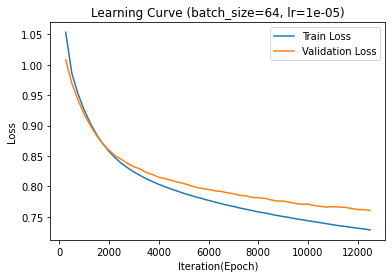

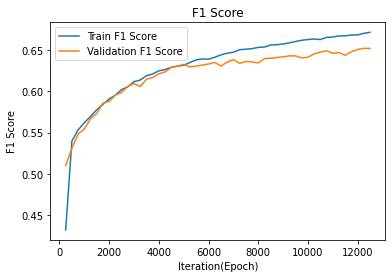

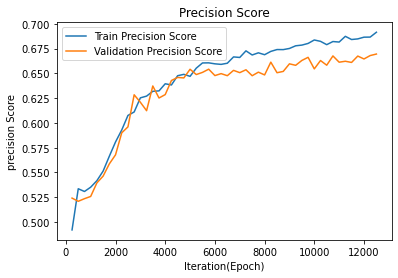

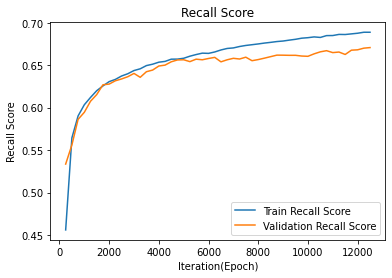

In [ ]:
validation = XVal
validation = validation.unsqueeze(1)
y_pred = model(validation)
# scores = nn.functional.softmax(y_pred, dim=1)
# print(YVal.shape)
# print(y_pred.shape)
fpr0 , tpr0, t0 = roc_curve(YVal.detach().numpy()[:,0],y_pred.detach().numpy()[:,0])
roc_auc0 = auc(fpr0, tpr0)
fpr1 , tpr1, t1 = roc_curve(YVal.detach().numpy()[:,1],y_pred.detach().numpy()[:,1])
roc_auc1 = auc(fpr1, tpr1)
fpr2 , tpr2, t2 = roc_curve(YVal.detach().numpy()[:,2],y_pred.detach().numpy()[:,2])
roc_auc2 = auc(fpr2, tpr2)

fprmicro , tprmicro, tmicro = roc_curve(YVal.ravel().detach().numpy(),y_pred.ravel().detach().numpy())
roc_aucmicro = auc(fprmicro, tprmicro)

# array_fpr = [fpr0,fpr1,fpr2]
# all_fpr = np.unique(np.concatenate([array_fpr[i] for i in range(3)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(3):
#     mean_tpr += np.interp(all_fpr, array_fpr[i], array_fpr[i])

# # Finally average it and compute AUC
# mean_tpr /= 3

# fprmacro = all_fpr
# tprmacro = mean_tpr
# roc_aucmacro = auc(fprmacro, tprmacro)
# print(fprmacro)

plt.plot(fpr0, tpr0, color='blue', lw=2,label='ROC curve of class 0 (area = {0:0.2f})'
''.format(roc_auc0))
plt.plot(fpr1, tpr1, color='red', lw=2,label='ROC curve of class 1 (area = {0:0.2f})'
''.format(roc_auc1))
plt.plot(fpr2, tpr2, color='green', lw=2,label='ROC curve of class 2 (area = {0:0.2f})'
''.format(roc_auc2))
plt.plot(fprmicro, tprmicro,':', color='grey', lw=2,label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_aucmicro))
# plt.plot(fprmacro, tprmacro,'k-.', color='grey', lw=2,label='macro-average ROC curve (area = {0:0.2f})'
# ''.format(roc_aucmacro))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

plt.title("Learning Curve (batch_size={}, lr={})".format(batchSize, learningRate))
plt.plot(iters, losses, label="Train Loss")
plt.plot(iters, losses_Val, label="Validation Loss")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("F1 Score")
plt.plot(iters, f1_train_scores, label="Train F1 Score")
plt.plot(iters, f1_train_scores_Val, label="Validation F1 Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

plt.title("Precision Score")
plt.plot(iters, precision_train_scores, label="Train Precision Score")
plt.plot(iters, precision_train_scores_Val, label="Validation Precision Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("precision Score")
plt.legend(loc='best')
plt.show()

plt.title("Recall Score")
plt.plot(iters, recall_train_scores, label="Train Recall Score")
plt.plot(iters, recall_train_scores_Val, label="Validation Recall Score")
plt.xlabel("Iteration(Epoch)")
plt.ylabel("Recall Score")
plt.legend(loc='best')
plt.show()